# Introduction 

## Problem


## Dataset

### JERICHO-E
The dataset provides the energy consumption of Germany in the whole year of 2019. <br>
The dataset is spatially resolved at the NUTS2 level conprising 38 regions and temporally resolved in hours.
Calculation separately for (4) application purposes: the residential, industrial, commerce and mobility sectors.
Consumption (7) patterns: space heating, hot water, process heat, space cooling, process cooling, mechanical energy, information communication technology, lighting.<br>
Totally, the dataset includes 28 consumption profiles per NUTS2 region.<br>
JERICHO-E-usage dataset provides a starting point for appropriate data to account for energy consumption patterns in energy system analyses with high temporal and spatial resolution. For the spatial distribution of energy consumption, rather simplified distribution keys – such as the GDP per capita.<br>
The Nomenclature of Territorial Units for Statistics (NUTS) is a geocode standard for referencing the subdivisions of Germany for statistical purposes


### Open power system data  
https://doi.org/10.25832/time_series/2020-10-06 <br>
This data package contains different kinds of timeseries data, including electricity consumption (load). The data is aggregated either by country, control area or bidding zone. All variables are provided in hourly resolution.
<br>
This notebook will extract data of Germany, covering the period 2015 to 2020.

### Eurostat
Eurostat plays in providing high-quality European statistics to policy, markers, businesses, researchers and the public at large. <br>
Data relating to poplution, GDP and Geodata is extracted from Eurostat database.


## Library

In [1]:
#!pip install xgboost

In [2]:
#!pip install geopandas

In [3]:
import geopandas as gpd

In [4]:
#read data
import pandas as pd
import numpy as np

#format date, time
from datetime import datetime as dt
from datetime import timedelta as td

#shape file
import geopandas as gpd

#visualization
import seaborn as sns
color_pal = sns.color_palette()
import matplotlib.pyplot as plt
import plotly.express as px
from matplotlib.animation import FuncAnimation
from itertools import count

%matplotlib inline
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

#Regression
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

#Unsupervised classification
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Time series
import xgboost as xgb


import warnings
warnings.filterwarnings('ignore')

# Temperature dataset

In [7]:
temp=pd.read_csv('./Dataset/1-temperature_scaling_NUTS2.csv')
temp.head()

hour      DE11      DE12      DE13      DE14      DE21      DE22      DE23  \
0     1  1.459768  1.355397  1.355397  1.459768  1.459768  1.459768  1.482948   
1     2  1.426779  1.345784  1.345784  1.426779  1.426779  1.426779  1.487671   
2     3  1.402037  1.340977  1.340977  1.402037  1.402037  1.402037  1.497116   
3     4  1.402037  1.340977  1.340977  1.402037  1.402037  1.402037  1.501839   
4     5  1.402037  1.345784  1.345784  1.402037  1.402037  1.402037  1.511284   

       DE24      DE25  ...      DEB1      DEB2      DEB3      DEC0      DED2  \
0  1.482948  1.459768  ...  1.539392  1.355397  1.539392  1.539392  1.309827   
1  1.487671  1.426779  ...  1.574040  1.345784  1.574040  1.574040  1.348810   
2  1.497116  1.402037  ...  1.603739  1.340977  1.603739  1.603739  1.379997   
3  1.501839  1.402037  ...  1.613639  1.340977  1.613639  1.613639  1.376098   
4  1.511284  1.402037  ...  1.618589  1.345784  1.618589  1.618589  1.376098   

       DED4      DED5      DEE0      DEF0      DEG0  
0  1.309827  1.309827  1.309827  1.619188  1.668407  
1  1.348810  1.348810  1.348810  1.658048  1.715039  
2  1.379997  1.379997  1.379997  1.679637  1.751309  
3  1.376098  1.376098  1.376098  1.679637  1.746127  
4  1.376098  1.376098  1.376098  1.675320  1.740946  

[5 rows x 39 columns]

In [8]:
# Create the starting date as a `datetime` object.
start = dt(2019, 1, 1, 0, 0, 0)
# List initialiser.
result = [start]


In [9]:
# Build a list of datetime objects for each hour of the year.
for i in range(1, 8760):
    start += td(seconds=3600)
    result.append(start)


In [10]:
# Initialise a DataFrame data structure.
df = pd.DataFrame({'dates': result})
# Add each column by extracting the object of interest from the datetime.
df['month'] = df['dates'].dt.month
df['day'] = df['dates'].dt.day
df['hours'] = df['dates'].dt.hour



In [11]:
df['hour'] = np.arange(1,len(df)+1)
df.shape

(8760, 5)

In [12]:
temp=pd.merge(df,temp, on='hour', how='left')

In [13]:
temp.head()

dates  month  day  hours  hour      DE11      DE12      DE13  \
0 2019-01-01 00:00:00      1    1      0     1  1.459768  1.355397  1.355397   
1 2019-01-01 01:00:00      1    1      1     2  1.426779  1.345784  1.345784   
2 2019-01-01 02:00:00      1    1      2     3  1.402037  1.340977  1.340977   
3 2019-01-01 03:00:00      1    1      3     4  1.402037  1.340977  1.340977   
4 2019-01-01 04:00:00      1    1      4     5  1.402037  1.345784  1.345784   

       DE14      DE21  ...      DEB1      DEB2      DEB3      DEC0      DED2  \
0  1.459768  1.459768  ...  1.539392  1.355397  1.539392  1.539392  1.309827   
1  1.426779  1.426779  ...  1.574040  1.345784  1.574040  1.574040  1.348810   
2  1.402037  1.402037  ...  1.603739  1.340977  1.603739  1.603739  1.379997   
3  1.402037  1.402037  ...  1.613639  1.340977  1.613639  1.613639  1.376098   
4  1.402037  1.402037  ...  1.618589  1.345784  1.618589  1.618589  1.376098   

       DED4      DED5      DEE0      DEF0      DEG0  
0  1.309827  1.309827  1.309827  1.619188  1.668407  
1  1.348810  1.348810  1.348810  1.658048  1.715039  
2  1.379997  1.379997  1.379997  1.679637  1.751309  
3  1.376098  1.376098  1.376098  1.679637  1.746127  
4  1.376098  1.376098  1.376098  1.675320  1.740946  

[5 rows x 43 columns]

In [14]:

temp.drop('hour', axis=1, inplace=True)

In [15]:
temp.rename(columns={"hours":"hour"},inplace=True)

In [16]:
temp.head(5)

dates  month  day  hour      DE11      DE12      DE13  \
0 2019-01-01 00:00:00      1    1     0  1.459768  1.355397  1.355397   
1 2019-01-01 01:00:00      1    1     1  1.426779  1.345784  1.345784   
2 2019-01-01 02:00:00      1    1     2  1.402037  1.340977  1.340977   
3 2019-01-01 03:00:00      1    1     3  1.402037  1.340977  1.340977   
4 2019-01-01 04:00:00      1    1     4  1.402037  1.345784  1.345784   

       DE14      DE21      DE22  ...      DEB1      DEB2      DEB3      DEC0  \
0  1.459768  1.459768  1.459768  ...  1.539392  1.355397  1.539392  1.539392   
1  1.426779  1.426779  1.426779  ...  1.574040  1.345784  1.574040  1.574040   
2  1.402037  1.402037  1.402037  ...  1.603739  1.340977  1.603739  1.603739   
3  1.402037  1.402037  1.402037  ...  1.613639  1.340977  1.613639  1.613639   
4  1.402037  1.402037  1.402037  ...  1.618589  1.345784  1.618589  1.618589   

       DED2      DED4      DED5      DEE0      DEF0      DEG0  
0  1.309827  1.309827  1.309827  1.309827  1.619188  1.668407  
1  1.348810  1.348810  1.348810  1.348810  1.658048  1.715039  
2  1.379997  1.379997  1.379997  1.379997  1.679637  1.751309  
3  1.376098  1.376098  1.376098  1.376098  1.679637  1.746127  
4  1.376098  1.376098  1.376098  1.376098  1.675320  1.740946  

[5 rows x 42 columns]

In [17]:
temp_month = temp.groupby(['month']).mean()
temp_month.drop(['day','hour'],axis=1, inplace=True)
temp_month

DE11      DE12      DE13      DE14      DE21      DE22      DE23  \
month                                                                         
1      1.412956  1.464373  1.464373  1.412956  1.412956  1.412956  1.451558   
2      1.362360  1.381209  1.381209  1.362360  1.362360  1.362360  1.383573   
3      1.190213  1.210928  1.210928  1.190213  1.190213  1.190213  1.238729   
4      0.986420  0.995239  0.995239  0.986420  0.986420  0.986420  0.994890   
5      0.779567  0.772372  0.772372  0.779567  0.779567  0.779567  0.783757   
6      0.662228  0.632118  0.632118  0.662228  0.662228  0.662228  0.642880   
7      0.601248  0.568101  0.568101  0.601248  0.601248  0.601248  0.574622   
8      0.636459  0.546117  0.546117  0.636459  0.636459  0.636459  0.565424   
9      0.805983  0.761897  0.761897  0.805983  0.805983  0.805983  0.774599   
10     0.990017  1.004247  1.004247  0.990017  0.990017  0.990017  0.980323   
11     1.226628  1.260758  1.260758  1.226628  1.226628  1.226628  1.219103   
12     1.370706  1.428241  1.428241  1.370706  1.370706  1.370706  1.415775   

           DE24      DE25      DE26  ...      DEB1      DEB2      DEB3  \
month                                ...                                 
1      1.451558  1.412956  1.412956  ...  1.425573  1.464373  1.425573   
2      1.383573  1.362360  1.362360  ...  1.360742  1.381209  1.360742   
3      1.238729  1.190213  1.190213  ...  1.220920  1.210928  1.220920   
4      0.994890  0.986420  0.986420  ...  1.012574  0.995239  1.012574   
5      0.783757  0.779567  0.779567  ...  0.800393  0.772372  0.800393   
6      0.642880  0.662228  0.662228  ...  0.676041  0.632118  0.676041   
7      0.574622  0.601248  0.601248  ...  0.587710  0.568101  0.587710   
8      0.565424  0.636459  0.636459  ...  0.586247  0.546117  0.586247   
9      0.774599  0.805983  0.805983  ...  0.776832  0.761897  0.776832   
10     0.980323  0.990017  0.990017  ...  0.980821  1.004247  0.980821   
11     1.219103  1.226628  1.226628  ...  1.210958  1.260758  1.210958   
12     1.415775  1.370706  1.370706  ...  1.385661  1.428241  1.385661   

           DEC0      DED2      DED4      DED5      DEE0      DEF0      DEG0  
month                                                                        
1      1.425573  1.376848  1.376848  1.376848  1.376848  1.336689  1.482127  
2      1.360742  1.318964  1.318964  1.318964  1.318964  1.303555  1.430240  
3      1.220920  1.194272  1.194272  1.194272  1.194272  1.214913  1.251918  
4      1.012574  0.991748  0.991748  0.991748  0.991748  1.025300  1.016149  
5      0.800393  0.810955  0.810955  0.810955  0.810955  0.859499  0.760062  
6      0.676041  0.700296  0.700296  0.700296  0.700296  0.725954  0.620284  
7      0.587710  0.622915  0.622915  0.622915  0.622915  0.630433  0.530633  
8      0.586247  0.641600  0.641600  0.641600  0.641600  0.638279  0.526593  
9      0.776832  0.810883  0.810883  0.810883  0.810883  0.797696  0.745853  
10     0.980821  1.002087  1.002087  1.002087  1.002087  0.987728  0.988168  
11     1.210958  1.199560  1.199560  1.199560  1.199560  1.174205  1.238294  
12     1.385661  1.351142  1.351142  1.351142  1.351142  1.326196  1.439075  

[12 rows x 38 columns]

# Comsumption data
Let's discovery the pattern of energy consumption temporally, spatially and sectorally

## EDA: Temporal - Sectoral


In [ ]:
# Energy consumption in 4 sectors, 28 profiles 
#1. graph area combine: 4 sectors total comsum on 8760 hours: which sector consumes the most, which sector change the most during a year
#2. 4 area graphs of 4 sectors

In [19]:
#cdf1 = pd.read_csv('../Dataset/Commerce/nuts2_hourly_com_Hot Water_kw.csv', parse_dates=['datetime'])
cdf1 = pd.read_csv('./Dataset/Commerce/nuts2_hourly_com_Hot Water_kw.csv')
cdf2 = pd.read_csv('./Dataset/Commerce/nuts2_hourly_com_Information_kw.csv')
cdf3 = pd.read_csv('./Dataset/Commerce/nuts2_hourly_com_Light_kw.csv')
cdf4 = pd.read_csv('./Dataset/Commerce/nuts2_hourly_com_Mechanical_kw.csv')
cdf5 = pd.read_csv('./Dataset/Commerce/nuts2_hourly_com_Process Cooling_kw.csv')
cdf6 = pd.read_csv('./Dataset/Commerce/nuts2_hourly_com_Process Heat-Direct_kw.csv')
cdf7 = pd.read_csv('./Dataset/Commerce/nuts2_hourly_com_Space Cooling_kw.csv')
cdf8 = pd.read_csv('./Dataset/Commerce/nuts2_hourly_com_Space Heat_kw.csv')



In [20]:
cdf1['c_hotwater']=cdf1.iloc[:,1:].sum(axis=1)
cdf1['c_information']=cdf2.iloc[:,1:].sum(axis=1)
cdf1['c_light']=cdf3.iloc[:,1:].sum(axis=1)
cdf1['c_mechanical']=cdf4.iloc[:,1:].sum(axis=1)
cdf1['c_process_cool']=cdf5.iloc[:,1:].sum(axis=1)
cdf1['c_process_heat']=cdf6.iloc[:,1:].sum(axis=1)
cdf1['c_space_cooling']=cdf7.iloc[:,1:].sum(axis=1)
cdf1['c_space_heat']=cdf8.iloc[:,1:].sum(axis=1)

In [21]:
cdf1.head(2)

utc_timestamp      DE11      DE12      DE13      DE14  \
0  2019-01-01 00:00:00+01:00  50619.26  32687.67  28149.85  24891.88   
1  2019-01-01 01:00:00+01:00  45620.08  29459.42  25369.76  22433.55   

       DE21      DE22      DE23      DE24      DE25  ...      DEF0      DEG0  \
0  70020.61  19863.05  16180.25  13536.05  23609.58  ...  40871.31  26345.95   
1  63105.35  17901.37  14582.29  12199.22  21277.89  ...  36834.85  23744.01   

   c_hotwater  c_information    c_light  c_mechanical  c_process_cool  \
0  1083602.78     1389809.97  222723.70    2253498.59      2217229.40   
1   976585.84     1252551.88  200727.43    2030942.31      1998255.09   

   c_process_heat  c_space_cooling  c_space_heat  
0      1777469.11        827285.42   12940474.32  
1      1601925.70        745582.42   11813564.10  

[2 rows x 47 columns]

In [22]:
com_pattern = cdf1.iloc[:, np.r_[0, -8:0]]
com_pattern['com_total'] = com_pattern.iloc[:, 1:].sum(axis=1)
com_pattern['utc_timestamp'] = pd.to_datetime(com_pattern['utc_timestamp'])
com_pattern.head(2)

utc_timestamp  c_hotwater  c_information    c_light  \
0 2019-01-01 00:00:00+01:00  1083602.78     1389809.97  222723.70   
1 2019-01-01 01:00:00+01:00   976585.84     1252551.88  200727.43   

   c_mechanical  c_process_cool  c_process_heat  c_space_cooling  \
0    2253498.59      2217229.40      1777469.11        827285.42   
1    2030942.31      1998255.09      1601925.70        745582.42   

   c_space_heat    com_total  
0   12940474.32  22712093.29  
1   11813564.10  20620134.77

In [23]:
idf1 = pd.read_csv('./Dataset/Industry/nuts2_hourly_ind_Hot Water_kw.csv')
idf2 = pd.read_csv('./Dataset/Industry/nuts2_hourly_ind_Information_kw.csv')
idf3 = pd.read_csv('./Dataset/Industry/nuts2_hourly_ind_Light_kw.csv')
idf4 = pd.read_csv('./Dataset/Industry/nuts2_hourly_ind_Mechanical_kw.csv')
idf5 = pd.read_csv('./Dataset/Industry/nuts2_hourly_ind_Process Cooling_kw.csv')
idf6 = pd.read_csv('./Dataset/Industry/nuts2_hourly_ind_Process Heat-Direct_kw.csv')
idf7 = pd.read_csv('./Dataset/Industry/nuts2_hourly_ind_Space Cooling_kw.csv')
idf8 = pd.read_csv('./Dataset/Industry/nuts2_hourly_ind_Space Heat_kw.csv')


In [24]:
idf1['i_hotwater']=idf1.iloc[:,1:].sum(axis=1)
idf1['i_information']=idf2.iloc[:,1:].sum(axis=1)
idf1['i_light']=idf3.iloc[:,1:].sum(axis=1)
idf1['i_mechanical']=idf4.iloc[:,1:].sum(axis=1)
idf1['i_process_cool']=idf5.iloc[:,1:].sum(axis=1)
idf1['i_process_heat']=idf6.iloc[:,1:].sum(axis=1)
idf1['i_space_cooling']=idf7.iloc[:,1:].sum(axis=1)
idf1['i_space_heat']=idf8.iloc[:,1:].sum(axis=1)

In [25]:
ind_pattern = idf1.iloc[:, np.r_[0, -8:0]]
ind_pattern['ind_total'] = ind_pattern.iloc[:, 1:].sum(axis=1)
ind_pattern['utc_timestamp'] = pd.to_datetime(ind_pattern['utc_timestamp'])
ind_pattern.head(2)

utc_timestamp  i_hotwater  i_information   i_light  \
0 2019-01-01 00:00:00+01:00   313078.97      542524.78  88242.59   
1 2019-01-01 01:00:00+01:00   309193.02      535790.94  87147.33   

   i_mechanical  i_process_cool  i_process_heat  i_space_cooling  \
0    9425204.08      2311530.47     34443992.48       1334722.43   
1    9308217.61      2282839.58     34016470.67       1318155.75   

   i_space_heat    ind_total  
0    3897308.23  52356604.03  
1    3889395.39  51747210.29

In [26]:
mdf1 = pd.read_csv('./Dataset/Mobility/nuts2_hourly_mob_Mechanical_kw.csv')
mdf2 = pd.read_csv('./Dataset/Mobility/nuts2_hourly_mob_service_Mot_km.csv')
mdf3 = pd.read_csv('./Dataset/Mobility/nuts2_hourly_mob_service_Oth_km.csv')
mdf4 = pd.read_csv('./Dataset/Mobility/nuts2_hourly_mob_service_Pas_km.csv')
mdf5 = pd.read_csv('./Dataset/Mobility/nuts2_hourly_mob_service_Tru_gr_35_km.csv')
mdf6 = pd.read_csv('./Dataset/Mobility/nuts2_hourly_mob_service_Tru_semi_km.csv')
mdf7 = pd.read_csv('./Dataset/Mobility/nuts2_hourly_mob_service_Tru_sm_35_km.csv')



In [27]:
mdf1.head(2)

utc_timestamp       DE11       DE12       DE13      DE14  \
0  2019-01-01 00:00:00+01:00  192635.66  125565.07  102281.07  87340.71   
1  2019-01-01 01:00:00+01:00  155427.13  101153.35   82216.37  70327.57   

        DE21      DE22      DE23      DE24      DE25  ...      DEB1      DEB2  \
0  217440.99  61963.50  58740.48  57722.90  90390.20  ...  81092.52  25766.77   
1  175695.50  49813.94  47308.63  47158.69  73824.28  ...  65584.84  20716.37   

        DEB3      DEC0      DED2      DED4      DED5       DEE0       DEF0  \
0  101620.56  51803.94  69594.82  68594.63  42628.37  103393.44  132769.76   
1   82732.89  42121.55  55055.06  54148.77  33875.07   81967.81  106004.77   

       DEG0  
0  98589.39  
1  77825.70  

[2 rows x 39 columns]

In [28]:
mob_pattern = mdf1.copy()
mob_pattern['m_mechanical'] = mdf1.iloc[:,1:].sum(axis=1) #read and save the mechanical file only for mobility pattern (unit kw)
mob_pattern = mob_pattern.iloc[:,np.r_[0,39]]
mob_pattern.head(2)
                

utc_timestamp  m_mechanical
0  2019-01-01 00:00:00+01:00    3778800.41
1  2019-01-01 01:00:00+01:00    3033271.85

In [29]:
mdf1['m_mechanical']=mdf1.iloc[:,1:].sum(axis=1)
mdf1['m_service_mot']=mdf2.iloc[:,1:].sum(axis=1)
mdf1['m_service_oth']=mdf3.iloc[:,1:].sum(axis=1)
mdf1['m_service_pas']=mdf4.iloc[:,1:].sum(axis=1)
mdf1['m_service_tru35']=mdf5.iloc[:,1:].sum(axis=1)
mdf1['m_service_tru_semi']=mdf6.iloc[:,1:].sum(axis=1)
mdf1['m_service_tru_sm35']=mdf7.iloc[:,1:].sum(axis=1)


In [30]:
mob_pattern_kwkm = mdf1.iloc[:, np.r_[0, -7:0]]
mob_pattern_kwkm['mob_total'] = mob_pattern_kwkm.iloc[:, 1:].sum(axis=1)
mob_pattern_kwkm['utc_timestamp'] = pd.to_datetime(mob_pattern_kwkm['utc_timestamp'])
mob_pattern_kwkm.head(2)

utc_timestamp  m_mechanical  m_service_mot  m_service_oth  \
0 2019-01-01 00:00:00+01:00    3778800.41      262535.16       39349.83   
1 2019-01-01 01:00:00+01:00    3033271.85      285976.74       81694.58   

   m_service_pas  m_service_tru35  m_service_tru_semi  m_service_tru_sm35  \
0    19076022.46         54597.25           120001.44          1626548.53   
1    15866088.18         63103.09            92241.27           808801.03   

     mob_total  
0  24957855.08  
1  20231176.74

In [31]:
rdf1 = pd.read_csv('./Dataset/Residential/nuts2_hourly_res_Hot Water_kw.csv')
rdf2 = pd.read_csv('./Dataset/Residential/nuts2_hourly_res_Information_kw.csv')
rdf3 = pd.read_csv('./Dataset/Residential/nuts2_hourly_res_Light_kw.csv')
rdf4 = pd.read_csv('./Dataset/Residential/nuts2_hourly_res_Mechanical_kw.csv')
rdf5 = pd.read_csv('./Dataset/Residential/nuts2_hourly_res_Process Cooling_kw.csv')
rdf6 = pd.read_csv('./Dataset/Residential/nuts2_hourly_res_Process Heat-Direct_kw.csv')
rdf7 = pd.read_csv('./Dataset/Residential/nuts2_hourly_res_Space Cooling_kw.csv')
rdf8 = pd.read_csv('./Dataset/Residential/nuts2_hourly_res_Space Heat_kw.csv')


In [32]:
rdf1['r_hotwater']=rdf1.iloc[:,1:].sum(axis=1)
rdf1['r_information']=rdf2.iloc[:,1:].sum(axis=1)
rdf1['r_light']=rdf3.iloc[:,1:].sum(axis=1)
rdf1['r_mechanical']=rdf4.iloc[:,1:].sum(axis=1)
rdf1['r_process_cool']=rdf5.iloc[:,1:].sum(axis=1)
rdf1['r_process_heat']=rdf6.iloc[:,1:].sum(axis=1)
rdf1['r_space_cooling']=rdf7.iloc[:,1:].sum(axis=1)
rdf1['r_space_heat']=rdf8.iloc[:,1:].sum(axis=1)

In [33]:
res_pattern = rdf1.iloc[:, np.r_[0, -8:0]]
res_pattern['res_total'] = res_pattern.iloc[:, 1:].sum(axis=1)
res_pattern['utc_timestamp'] = pd.to_datetime(res_pattern['utc_timestamp'])
res_pattern.head(2)

utc_timestamp  r_hotwater  r_information   r_light  \
0 2019-01-01 00:00:00+01:00     1229.62     1288002.72  42547.15   
1 2019-01-01 01:00:00+01:00     2526.21     1300208.80  42950.37   

   r_mechanical  r_process_cool  r_process_heat  r_space_cooling  \
0     264711.55      5065846.96      2816670.34        203228.10   
1     267220.14      5113854.63      2843363.14        205154.04   

   r_space_heat    res_total  
0   62290744.54  71972980.98  
1   64305315.71  74080593.04

In [34]:
com_pattern.columns

Index(['utc_timestamp', 'c_hotwater', 'c_information', 'c_light',
       'c_mechanical', 'c_process_cool', 'c_process_heat', 'c_space_cooling',
       'c_space_heat', 'com_total'],
      dtype='object')

In [35]:
ind_pattern.iloc[:,-1]

0       52356604.03
1       51747210.29
2       50883674.22
3       49994506.92
4       50626294.18
           ...     
8755    86587287.44
8756    84065733.17
8757    81930077.86
8758    79382929.06
8759    77539608.73
Name: ind_total, Length: 8760, dtype: float64

In [36]:
total_pattern=com_pattern.iloc[:,np.r_[0,-1]]
total_pattern['ind_total'] = ind_pattern.iloc[:,-1].copy()
total_pattern['mob_total'] = mob_pattern.iloc[:,-1].copy()
total_pattern['res_total'] = res_pattern.iloc[:,-1].copy()

In [37]:
total_pattern.head(2) #mobility just includes mechanical profile, the other profile are measured in the unit of km.

utc_timestamp    com_total    ind_total   mob_total    res_total
0 2019-01-01 00:00:00+01:00  22712093.29  52356604.03  3778800.41  71972980.98
1 2019-01-01 01:00:00+01:00  20620134.77  51747210.29  3033271.85  74080593.04

In [38]:
total_pattern['utc_timestamp'] = pd.to_datetime(total_pattern['utc_timestamp'])
total_pattern['month'] = total_pattern['utc_timestamp'].dt.month
total_pattern['day'] = total_pattern['utc_timestamp'].dt.day
total_pattern['hour'] = total_pattern['utc_timestamp'].dt.hour
total_pattern.head(2)

utc_timestamp    com_total    ind_total   mob_total  \
0 2019-01-01 00:00:00+01:00  22712093.29  52356604.03  3778800.41   
1 2019-01-01 01:00:00+01:00  20620134.77  51747210.29  3033271.85   

     res_total  month  day  hour  
0  71972980.98      1    1     0  
1  74080593.04      1    1     1

In [39]:
total_pattern['day_of_week'] = total_pattern['utc_timestamp'].dt.day_name()

In [40]:
total_pattern.head(2)

utc_timestamp    com_total    ind_total   mob_total  \
0 2019-01-01 00:00:00+01:00  22712093.29  52356604.03  3778800.41   
1 2019-01-01 01:00:00+01:00  20620134.77  51747210.29  3033271.85   

     res_total  month  day  hour day_of_week  
0  71972980.98      1    1     0     Tuesday  
1  74080593.04      1    1     1     Tuesday

In [41]:
total = total_pattern.drop(['day','hour','month'], axis=1).set_index('utc_timestamp')

<AxesSubplot:xlabel='utc_timestamp'>

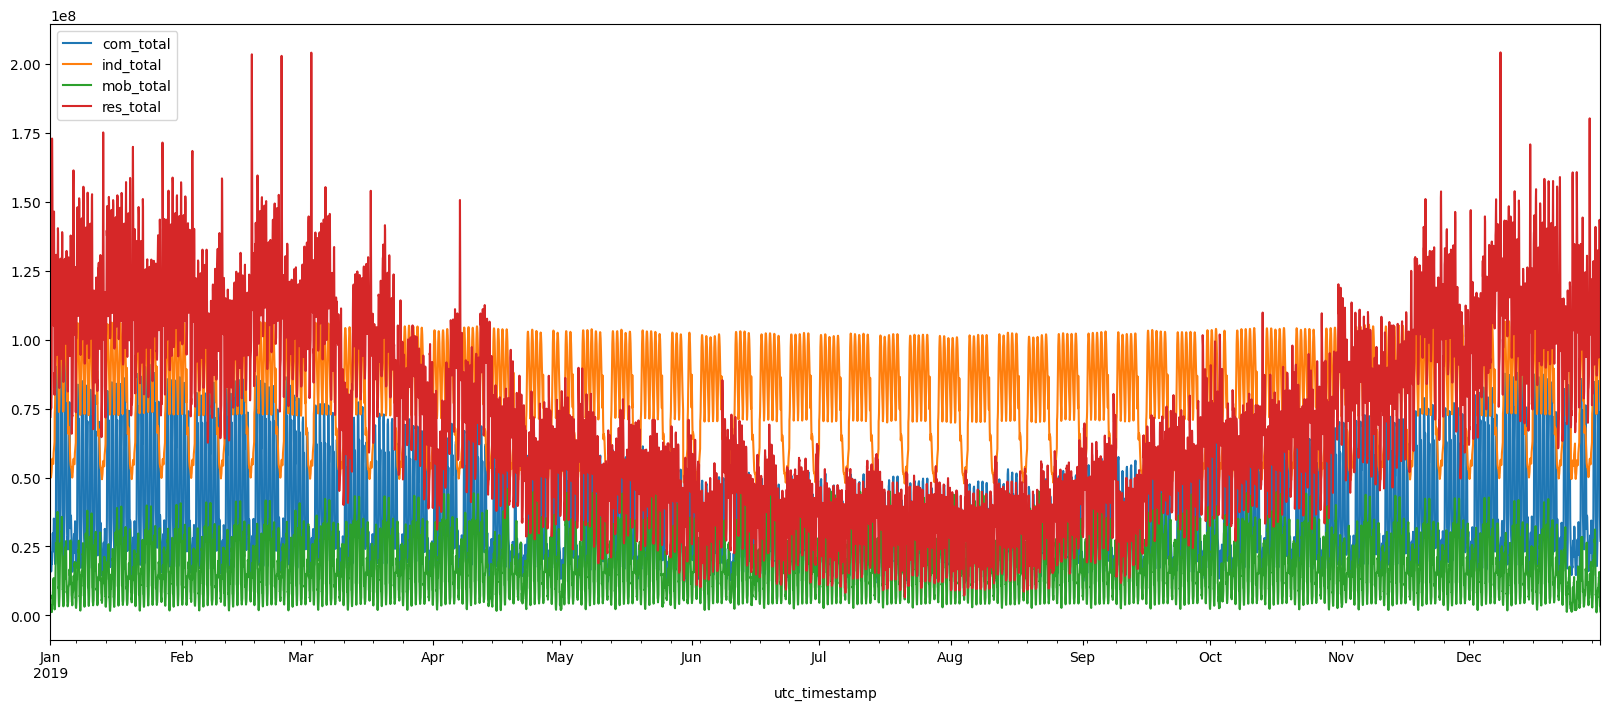

In [42]:
total.plot(figsize=(20,8))


In [43]:
total_month= total_pattern.groupby(['month']).mean().drop(['day','hour'], axis=1)


In [44]:
total_month.head(2)

com_total     ind_total     mob_total     res_total
month                                                        
1      4.349383e+07  8.223855e+07  1.564605e+07  1.147797e+08
2      4.260857e+07  8.225434e+07  1.715477e+07  1.094715e+08

In [45]:
total_month=total_month.reset_index()

In [46]:
total_month.head(2)

month     com_total     ind_total     mob_total     res_total
0      1  4.349383e+07  8.223855e+07  1.564605e+07  1.147797e+08
1      2  4.260857e+07  8.225434e+07  1.715477e+07  1.094715e+08

In [ ]:
#!pip install PyQt5

In [47]:
from matplotlib import animation

In [48]:
from matplotlib.animation import FuncAnimation

import PyQt5

In [49]:
%matplotlib qt
x = []
y = []
fig, ax = plt.subplots()
ax.plot(x,y)

counter = count(0,1)
def update(i):
    idx = next(counter)
    x.append(total_month.iloc[idx,0])
    y.append(total_month.iloc[idx,1])
    plt.cla()
    ax.plot(x,y,scaley=True, scalex=True, color='blue')
     

ani = FuncAnimation (fig, update, frames = 100,interval=300)
plt.show()



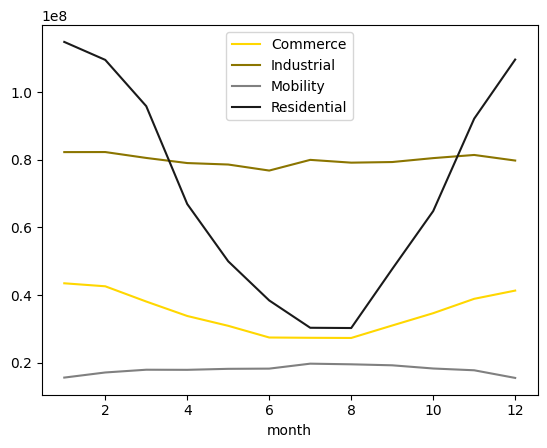

In [50]:
%matplotlib inline
legend = ['Commerce', 'Industrial', 'Mobility', 'Residential']
ax = total_month.set_index('month').plot(color = ['#FFD700','#8B7500','#808080','#1A1A1A'])
ax.legend(legend,loc='upper center',fontsize=10) 



During a year, energy consumption pattern of commerce sector observes the biggest fluctuation. It means, we can a lot of energy during summer from this sector. But this doesn't happen for the other sectors. Specially, demand of energy in industry always high during a year.

In [51]:
%matplotlib qt
fig, axes = plt.subplots()
#axes.set_xlim (0,12)
#axes.set_ylim(0,200000000)
#axes.set_title ('Monthly pattern of energy consumption in different sectors')
plt.style.use('seaborn')
x, y1, y2, y3, y4 = [],[],[],[],[]
legend = ['Commerce', 'Industrial', 'Mobility', 'Residential']

counter = count(0,1)
def update(i):
    idx = next(counter)
    x.append(total_month.iloc[idx,0])
    y1.append(total_month.iloc[idx,1])
    y2.append(total_month.iloc[idx,2])
    y3.append(total_month.iloc[idx,3])
    y4.append(total_month.iloc[idx,4])
    plt.cla()
    axes.plot(x,y1,scaley=True, scalex=True, color='#FFD700',label='Commerce')
    axes.plot(x,y2,scaley=True, scalex=True, color='#8B7500', label='Industry')
    axes.plot(x,y3,scaley=True, scalex=True, color='#808080', label='Mobility')
    axes.plot(x,y4,scaley=True, scalex=True, color='#1C1C1C',label='Residential')
    axes.legend(legend, loc = 'upper center')
    
ani = FuncAnimation (fig, update, interval=500, frames=100, repeat=False, blit=False)
plt.show()    


In [52]:
total_hour= total_pattern.groupby(['hour']).mean().drop(['day','month'], axis=1)


In [53]:
total_hour.head(2)

com_total     ind_total     mob_total     res_total
hour                                                        
0     2.184899e+07  7.061181e+07  4.948101e+06  4.781332e+07
1     1.957478e+07  7.023028e+07  4.159592e+06  4.727604e+07

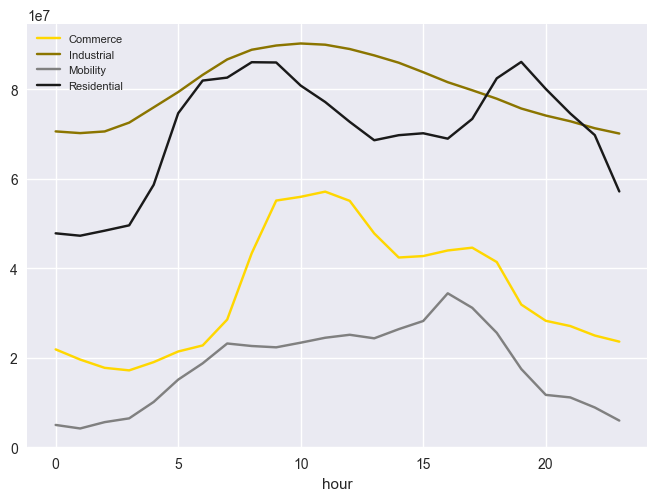

In [54]:
%matplotlib inline
ax = total_hour.plot(color=['#FFD700','#8B7500','#808080','#1A1A1A'])
ax.legend(legend, fontsize=8)

Normally, there are 2 peaks of energy consumption daily.

In [55]:
total_hour1 = total_hour.reset_index()

In [56]:
%matplotlib qt

import ffmpeg
from matplotlib.animation import FuncAnimation, writers
fig, axes = plt.subplots()
#axes.set_xlim (0,12)
#axes.set_ylim(0,200000000)
#axes.set_title ('Monthly pattern of energy consumption in different sectors')
plt.style.use('seaborn')
x, y1, y2, y3, y4 = [],[],[],[],[]


counter = count(0,1)
def update(i):
    idx = next(counter)
    x.append(total_hour1.iloc[idx,0])
    y1.append(total_hour1.iloc[idx,1])
    y2.append(total_hour1.iloc[idx,2])
    y3.append(total_hour1.iloc[idx,3])
    y4.append(total_hour1.iloc[idx,4])
    plt.cla()
    axes.plot(x,y1,scaley=True, scalex=True, color='#FFD700',label='Commerce')
    axes.plot(x,y2,scaley=True, scalex=True, color='#8B7500', label='Industrial')
    axes.plot(x,y3,scaley=True, scalex=True, color='#808080', label='Mobility')
    axes.plot(x,y4,scaley=True, scalex=True, color='#1C1C1C',label='Residential')
    axes.legend(legend, loc='upper left',fontsize=8)
    axes.xaxis.set_label_text('Hour')
    
    
ani = FuncAnimation (fig, update, interval=300, frames=100) #repeat=False,blit=False)

plt.show()    

In [57]:
total_dayofweek= total_pattern.groupby(['day_of_week']).mean().drop(['day','hour','month'], axis=1)


In [58]:
total_dayofweek.head(2)

com_total     ind_total     mob_total     res_total
day_of_week                                                        
Friday       3.829076e+07  8.904073e+07  1.861016e+07  7.057476e+07
Monday       3.796311e+07  8.835441e+07  1.787298e+07  6.874840e+07

Text(0.5, 0, '')

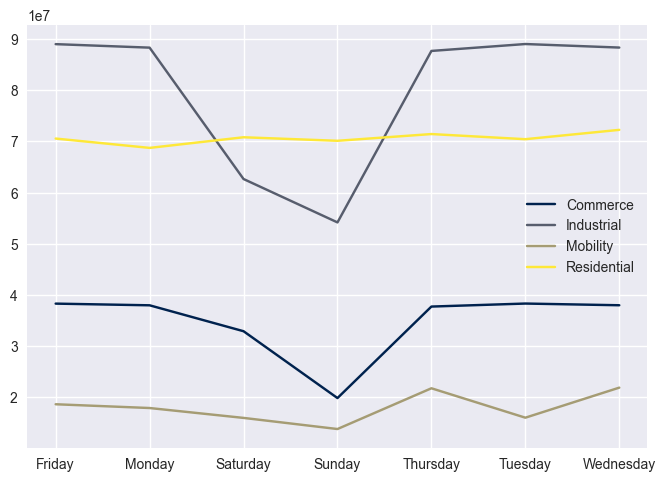

In [59]:
%matplotlib inline
ax = total_dayofweek.plot(cmap='cividis')
ax.legend(legend)
ax.xaxis.set_label_text('')

Energy consumption falls down during weekend in the sectors of commerce and industry, but the pattern doesn't change much during a week for residential sector.

In [60]:
total_dow = total_dayofweek.reset_index()

In [61]:
%matplotlib qt
fig, axes = plt.subplots()
#axes.set_xlim (0,12)
#axes.set_ylim(0,200000000)
#axes.set_title ('Monthly pattern of energy consumption in different sectors')
plt.style.use('seaborn')
x, y1, y2, y3, y4 = [],[],[],[],[]


counter = count(0,1)
def update(i):
    idx = next(counter)
    x.append(total_dow.iloc[idx,0])
    y1.append(total_dow.iloc[idx,1])
    y2.append(total_dow.iloc[idx,2])
    y3.append(total_dow.iloc[idx,3])
    y4.append(total_dow.iloc[idx,4])
    plt.cla()
    
    axes.plot(x,y1,scaley=True, scalex=True, color='#FFD700',label='Commerce')
    axes.plot(x,y2,scaley=True, scalex=True, color='#8B7500', label='Industrial')
    axes.plot(x,y3,scaley=True, scalex=True, color='#808080', label='Mobility')
    axes.plot(x,y4,scaley=True, scalex=True, color='#1C1C1C',label='Residential')
    axes.legend(legend, loc='center right')
    
ani = FuncAnimation (fig, update, interval=800, frames=100, repeat=False)
plt.show()    


In [62]:
# area chart of each sector


In [63]:

com_pattern.head(2)

utc_timestamp  c_hotwater  c_information    c_light  \
0 2019-01-01 00:00:00+01:00  1083602.78     1389809.97  222723.70   
1 2019-01-01 01:00:00+01:00   976585.84     1252551.88  200727.43   

   c_mechanical  c_process_cool  c_process_heat  c_space_cooling  \
0    2253498.59      2217229.40      1777469.11        827285.42   
1    2030942.31      1998255.09      1601925.70        745582.42   

   c_space_heat    com_total  
0   12940474.32  22712093.29  
1   11813564.10  20620134.77

In [64]:
com_pattern1 = com_pattern.set_index('utc_timestamp')
com_pattern1.drop(['com_total'], axis=1, inplace=True)
com_pattern1.head(2)

c_hotwater  c_information    c_light  c_mechanical  \
utc_timestamp                                                                   
2019-01-01 00:00:00+01:00  1083602.78     1389809.97  222723.70    2253498.59   
2019-01-01 01:00:00+01:00   976585.84     1252551.88  200727.43    2030942.31   

                           c_process_cool  c_process_heat  c_space_cooling  \
utc_timestamp                                                                
2019-01-01 00:00:00+01:00      2217229.40      1777469.11        827285.42   
2019-01-01 01:00:00+01:00      1998255.09      1601925.70        745582.42   

                           c_space_heat  
utc_timestamp                            
2019-01-01 00:00:00+01:00   12940474.32  
2019-01-01 01:00:00+01:00   11813564.10

In [65]:
ind_pattern1 = ind_pattern.set_index('utc_timestamp')
ind_pattern1.drop(['ind_total'], axis=1, inplace=True)
ind_pattern1.head(2)

i_hotwater  i_information   i_light  i_mechanical  \
utc_timestamp                                                                  
2019-01-01 00:00:00+01:00   313078.97      542524.78  88242.59    9425204.08   
2019-01-01 01:00:00+01:00   309193.02      535790.94  87147.33    9308217.61   

                           i_process_cool  i_process_heat  i_space_cooling  \
utc_timestamp                                                                
2019-01-01 00:00:00+01:00      2311530.47     34443992.48       1334722.43   
2019-01-01 01:00:00+01:00      2282839.58     34016470.67       1318155.75   

                           i_space_heat  
utc_timestamp                            
2019-01-01 00:00:00+01:00    3897308.23  
2019-01-01 01:00:00+01:00    3889395.39

In [66]:
mob_pattern1 = mob_pattern.set_index('utc_timestamp')

mob_pattern1.head(2)

m_mechanical
utc_timestamp                          
2019-01-01 00:00:00+01:00    3778800.41
2019-01-01 01:00:00+01:00    3033271.85

In [67]:
res_pattern1 = res_pattern.set_index('utc_timestamp')
res_pattern1.drop(['res_total'], axis=1, inplace=True)
res_pattern1.head(2)

r_hotwater  r_information   r_light  r_mechanical  \
utc_timestamp                                                                  
2019-01-01 00:00:00+01:00     1229.62     1288002.72  42547.15     264711.55   
2019-01-01 01:00:00+01:00     2526.21     1300208.80  42950.37     267220.14   

                           r_process_cool  r_process_heat  r_space_cooling  \
utc_timestamp                                                                
2019-01-01 00:00:00+01:00      5065846.96      2816670.34        203228.10   
2019-01-01 01:00:00+01:00      5113854.63      2843363.14        205154.04   

                           r_space_heat  
utc_timestamp                            
2019-01-01 00:00:00+01:00   62290744.54  
2019-01-01 01:00:00+01:00   64305315.71

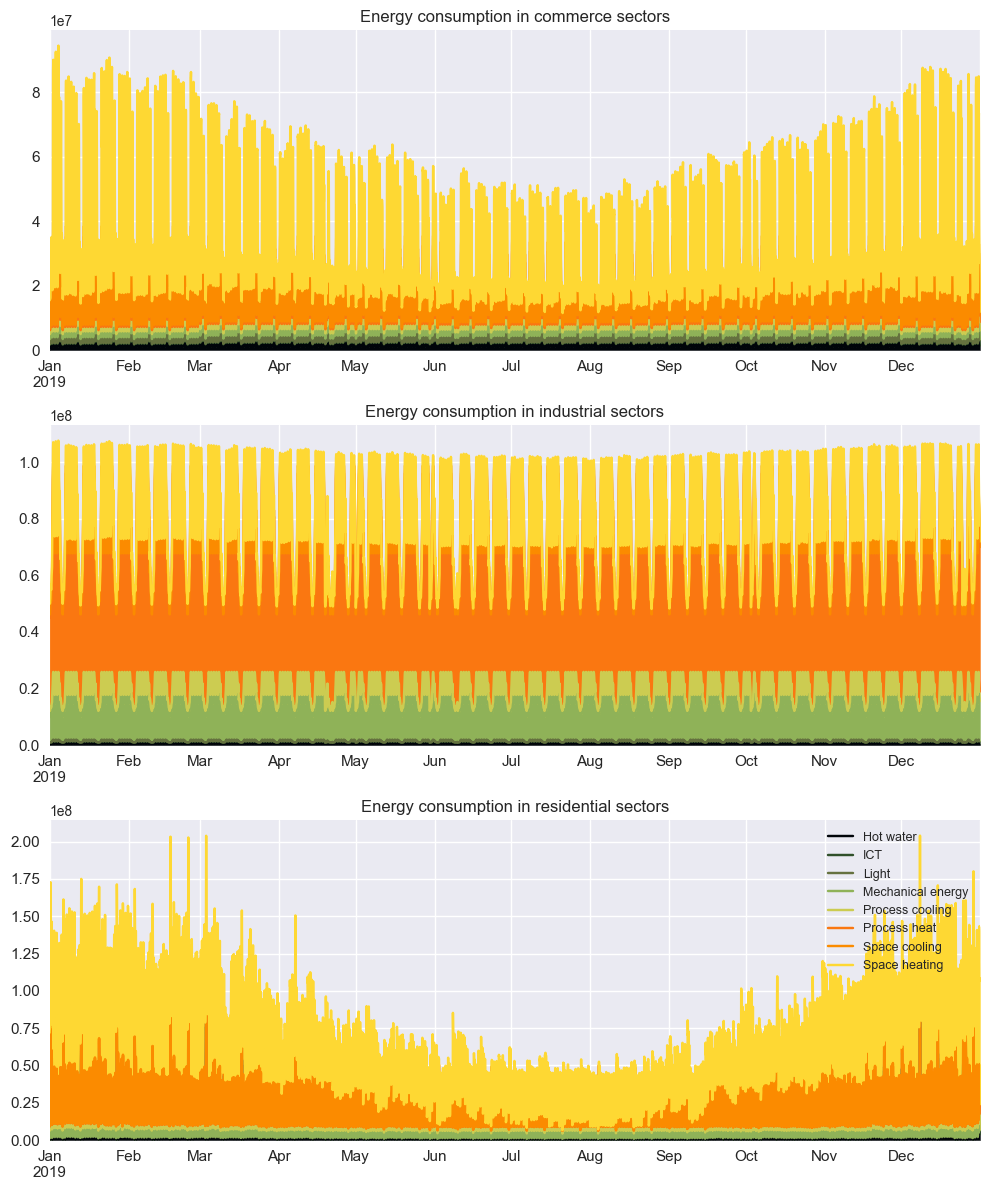

<Figure size 800x550 with 0 Axes>

In [69]:
%matplotlib inline
legend1 = ['Hot water','ICT', 'Light', 'Mechanical energy', 'Process cooling','Process heat', 'Space cooling', 'Space heating']

#color= ['#EFECEC','#C89C76','#404348','#FFB81D','#30502A','#65713F','#DD9A2E','#FFB81D']

fig,axes = plt.subplots(nrows=3, ncols=1, figsize = (10,12), sharex=False)


com_pattern1.plot.area (ax=axes[0],color=['#000409','#30502A','#65713F','#8FB258','#CCCC51','#FA7711','#FB8B00','#FED833'],
                                     title = 'Energy consumption in commerce sectors',fontsize=11)
axes[0].xaxis.set_label_text('')
axes[0].legend('')

ind_pattern1.plot.area (ax=axes[1], color=['#000409','#30502A','#65713F','#8FB258','#CCCC51','#FA7711','#FB8B00','#FED833'],
                                     title = 'Energy consumption in industrial sectors',fontsize=11)
axes[1].xaxis.set_label_text('')
axes[1].legend('')



res_pattern1.plot.area (ax=axes[2], color=['#000409','#30502A','#65713F','#8FB258','#CCCC51','#FA7711','#FB8B00','#FED833'],
                                     title = 'Energy consumption in residential sectors',fontsize=11)

axes[2].xaxis.set_label_text('')
axes[2].legend(legend1,fontsize=9, loc = 'upper right')
plt.tight_layout()
plt.show()
plt.savefig('tem_sec')


Looking inside each sector will see the way they share energy is different. 
In residential sector, most of energy is used for space heating, space cooling. This is similar to commercial sector. 
In industrial sector, demand of mechanical energy is significant higher.

In [71]:
com_perc = com_pattern1.divide(com_pattern1.sum(axis=1), axis=0)
ind_perc = ind_pattern1.divide(ind_pattern1.sum(axis=1), axis=0)

res_perc = res_pattern1.divide(res_pattern1.sum(axis=1), axis=0)

In [72]:
list(range(10,1,-1))

[10, 9, 8, 7, 6, 5, 4, 3, 2]

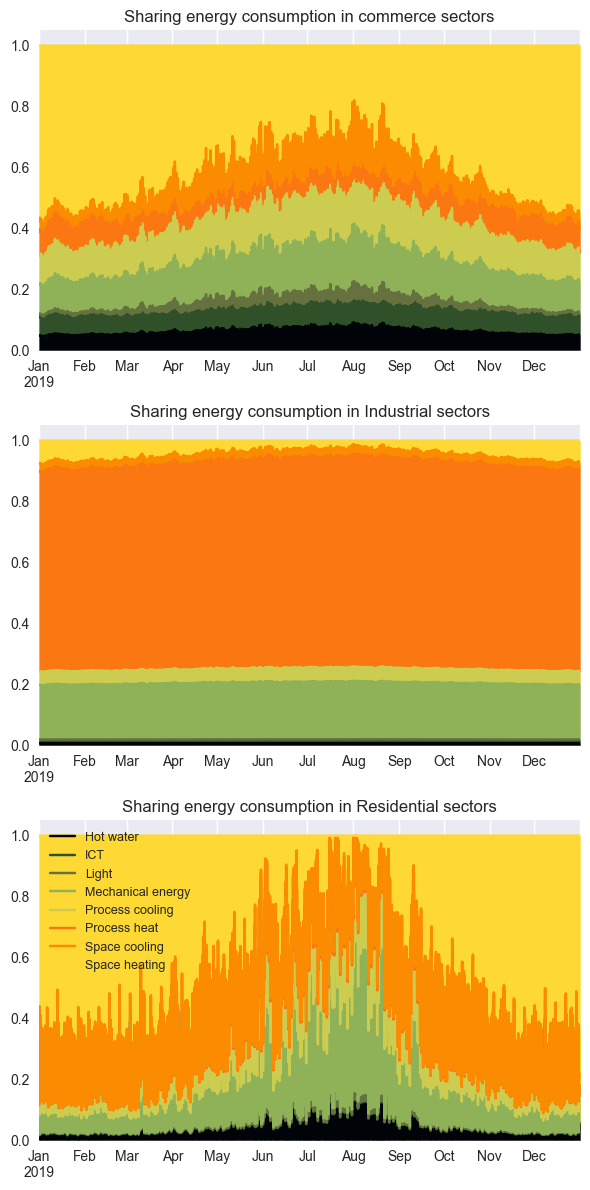

In [73]:
legend1 = ['Hot water','ICT', 'Light', 'Mechanical energy', 'Process cooling','Process heat', 'Space cooling', 'Space heating']


f = plt.figure(figsize = (6,12))
ax1=f.add_subplot(311)
com_perc.plot(kind = 'area',ax = ax1, title = 'Sharing energy consumption in commerce sectors',
             color=['#000409','#30502A','#65713F','#8FB258','#CCCC51','#FA7711','#FB8B00','#FED833'])
ax1.legend('')#legend1,fontsize=9, bbox_to_anchor=(1,1)
plt.xlabel('')


ax2=f.add_subplot(312)
ind_perc.plot(kind = 'area',ax = ax2, title = 'Sharing energy consumption in Industrial sectors',
             color=['#000409','#30502A','#65713F','#8FB258','#CCCC51','#FA7711','#FB8B00','#FED833'])
ax2.legend('')
plt.xlabel('')

# ax3=f.add_subplot(223)
# mob_perc.plot(kind = 'area',ax = ax3,  title = 'Sharing energy consumption in Mobility sectors',colormap='Spectral')
# ax3.legend(legend2,fontsize=9)


ax4=f.add_subplot(313)
res_perc.plot(kind = 'area',ax = ax4,  title = 'Sharing energy consumption in Residential sectors',
             color=['#000409','#30502A','#65713F','#8FB258','#CCCC51','#FA7711','#FB8B00','#FED833'])
ax4.legend(legend1, fontsize=9)

plt.xlabel('')
plt.tight_layout()
plt.show()

## EDA - Spatial - Sectoral

In [74]:
#energy consumption in 38 regions

In [75]:
cdf1.head(2)


utc_timestamp      DE11      DE12      DE13      DE14  \
0  2019-01-01 00:00:00+01:00  50619.26  32687.67  28149.85  24891.88   
1  2019-01-01 01:00:00+01:00  45620.08  29459.42  25369.76  22433.55   

       DE21      DE22      DE23      DE24      DE25  ...      DEF0      DEG0  \
0  70020.61  19863.05  16180.25  13536.05  23609.58  ...  40871.31  26345.95   
1  63105.35  17901.37  14582.29  12199.22  21277.89  ...  36834.85  23744.01   

   c_hotwater  c_information    c_light  c_mechanical  c_process_cool  \
0  1083602.78     1389809.97  222723.70    2253498.59      2217229.40   
1   976585.84     1252551.88  200727.43    2030942.31      1998255.09   

   c_process_heat  c_space_cooling  c_space_heat  
0      1777469.11        827285.42   12940474.32  
1      1601925.70        745582.42   11813564.10  

[2 rows x 47 columns]

In [76]:
cdf2.tail(2)

utc_timestamp      DE11      DE12      DE13      DE14  \
8758  2019-12-31 22:00:00+01:00  82898.02  53531.86  46100.38  40764.88   
8759  2019-12-31 23:00:00+01:00  78122.67  50448.15  43444.76  38416.61   

           DE21      DE22      DE23      DE24      DE25  ...      DEB1  \
8758  114671.19  32529.27  26498.04  22167.69  38664.88  ...  29273.16   
8759  108065.53  30655.42  24971.62  20890.71  36437.59  ...  27586.88   

          DEB2      DEB3      DEC0      DED2      DED4      DED5      DEE0  \
8758  12712.42  46231.52  17579.58  32385.62  27012.78  21409.67  45522.97   
8759  11980.12  43568.34  16566.90  30520.04  25456.70  20176.37  42900.61   

          DEF0      DEG0  
8758  66934.04  43146.17  
8759  63078.29  40660.72  

[2 rows x 39 columns]

In [77]:
cdf3.head(2)

utc_timestamp      DE11     DE12     DE13     DE14      DE21  \
0  2019-01-01 00:00:00+01:00  10404.28  6718.62  5785.92  5116.28  14392.03   
1  2019-01-01 01:00:00+01:00   9376.75  6055.09  5214.50  4610.99  12970.67   

      DE22     DE23     DE24     DE25  ...     DEB1     DEB2     DEB3  \
0  4082.65  3325.69  2782.20  4852.71  ...  3673.99  1595.50  5802.38   
1  3679.45  2997.24  2507.43  4373.46  ...  3311.14  1437.93  5229.33   

      DEC0     DED2     DED4     DED5     DEE0     DEF0     DEG0  
0  2206.36  4064.62  3390.29  2687.06  5713.45  8400.69  5415.15  
1  1988.46  3663.20  3055.47  2421.69  5149.19  7571.03  4880.34  

[2 rows x 39 columns]

In [78]:
70*8760*8

4905600

In [79]:
cdf1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8760 entries, 0 to 8759
Data columns (total 47 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   utc_timestamp    8760 non-null   object 
 1   DE11             8760 non-null   float64
 2   DE12             8760 non-null   float64
 3   DE13             8760 non-null   float64
 4   DE14             8760 non-null   float64
 5   DE21             8760 non-null   float64
 6   DE22             8760 non-null   float64
 7   DE23             8760 non-null   float64
 8   DE24             8760 non-null   float64
 9   DE25             8760 non-null   float64
 10  DE26             8760 non-null   float64
 11  DE27             8760 non-null   float64
 12  DE30             8760 non-null   float64
 13  DE40             8760 non-null   float64
 14  DE50             8760 non-null   float64
 15  DE60             8760 non-null   float64
 16  DE71             8760 non-null   float64
 17  DE72          

In [80]:
cdf1_c = cdf1.iloc[:,0:39]
idf1_c = idf1.iloc[:,0:39]
mdf1_c = mdf1.iloc[:,0:39]
rdf1_c = rdf1.iloc[:,0:39]

In [81]:
8760*8

70080

In [82]:
com_NUTS2 = pd.concat([cdf1_c,cdf2,cdf3,cdf4,cdf5,cdf6,cdf7,cdf8])
ind_NUTS2 = pd.concat([idf1_c,idf2,idf3,idf4,idf5,idf6,idf7,idf8])
mob_NUTS2 = mdf1_c.copy() #just analyse on data of mechanical (the other profiles have the unit of km)
res_NUTS2 = pd.concat([rdf1_c,rdf2,rdf3,rdf4,rdf5,rdf6,rdf7,rdf8])

In [83]:
com_NUTS2t = com_NUTS2.iloc[:,1:].T.reset_index(False)
com_NUTS2t.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38 entries, 0 to 37
Columns: 70081 entries, index to 8759
dtypes: float64(70080), object(1)
memory usage: 20.3+ MB


In [84]:
com_NUTS2t['com_sum'] = com_NUTS2t.iloc[:,1:].sum(axis=1)
com_NUTS2t.head(2)

index         0         1         2         3         4         5         6  \
0  DE11  50619.26  45620.08  40014.31  35893.65  35036.06  36060.99  40286.23   
1  DE12  32687.67  29459.42  25839.47  23178.53  22624.73  23286.59  26015.06   

          7         8  ...        8751        8752        8753        8754  \
0  43110.04  41394.84  ...  1915755.56  2090633.38  2147245.85  1920020.13   
1  27838.55  26730.95  ...  1111570.43  1212688.39  1251780.09  1131645.65   

         8755        8756       8757       8758       8759       com_sum  
0  1333652.27  1041822.37  915349.24  801247.40  738852.87  1.416321e+10  
1   764166.37   593297.72  517628.44  460412.17  430834.48  9.171160e+09  

[2 rows x 70082 columns]

In [85]:
com_NUTS2t.drop(com_NUTS2t.iloc[:,1:-1].columns, axis=1, inplace=True)
com_NUTS2t.head(2)

index       com_sum
0  DE11  1.416321e+10
1  DE12  9.171160e+09

In [86]:
com_NUTS2t.rename(columns={'index':'NUTS2'}, inplace=True)
com_NUTS2t.head(2)

NUTS2       com_sum
0  DE11  1.416321e+10
1  DE12  9.171160e+09

In [87]:

x=com_NUTS2t['com_sum'] 
pd.set_option('display.float_format', lambda x: '%.2f' % x)
com_NUTS2t['com_MWsum'] = round(com_NUTS2t['com_sum']/1000,2)
com_NUTS2t.head(2)

NUTS2        com_sum   com_MWsum
0  DE11 14163205459.89 14163205.46
1  DE12  9171159640.45  9171159.64

In [88]:
com_NUTS2t = com_NUTS2.iloc[:,1:].T.reset_index(False)
com_NUTS2t['com_sum'] = com_NUTS2t.iloc[:,1:].sum(axis=1)
com_NUTS2t.drop(com_NUTS2t.iloc[:,1:-1].columns, axis=1, inplace=True)
com_NUTS2t.rename(columns={'index':'NUTS2'}, inplace=True)

x=com_NUTS2t['com_sum'] 
pd.set_option('display.float_format', lambda x: '%.2f' % x)
com_NUTS2t['com_MWsum'] = round(com_NUTS2t['com_sum']/1000,2)
com_NUTS2t.head(2)


NUTS2        com_sum   com_MWsum
0  DE11 14163205459.89 14163205.46
1  DE12  9171159640.45  9171159.64

In [89]:
ind_NUTS2t = ind_NUTS2.iloc[:,1:].T.reset_index(False)
ind_NUTS2t['ind_sum'] = ind_NUTS2t.iloc[:,1:].sum(axis=1)
ind_NUTS2t.drop(ind_NUTS2t.iloc[:,1:-1].columns, axis=1, inplace=True)
ind_NUTS2t.rename(columns={'index':'NUTS2'}, inplace=True)

x=ind_NUTS2t['ind_sum'] 
pd.set_option('display.float_format', lambda x: '%.2f' % x)
ind_NUTS2t['ind_MWsum'] = round(ind_NUTS2t['ind_sum']/1000,2)
ind_NUTS2t.head(2)

NUTS2        ind_sum   ind_MWsum
0  DE11 46982471615.27 46982471.62
1  DE12 25456051647.27 25456051.65

In [90]:
mob_NUTS2.head(2)

utc_timestamp      DE11      DE12      DE13     DE14      DE21  \
0  2019-01-01 00:00:00+01:00 192635.66 125565.07 102281.07 87340.71 217440.99   
1  2019-01-01 01:00:00+01:00 155427.13 101153.35  82216.37 70327.57 175695.50   

      DE22     DE23     DE24     DE25  ...     DEB1     DEB2      DEB3  \
0 61963.50 58740.48 57722.90 90390.20  ... 81092.52 25766.77 101620.56   
1 49813.94 47308.63 47158.69 73824.28  ... 65584.84 20716.37  82732.89   

      DEC0     DED2     DED4     DED5      DEE0      DEF0     DEG0  
0 51803.94 69594.82 68594.63 42628.37 103393.44 132769.76 98589.39  
1 42121.55 55055.06 54148.77 33875.07  81967.81 106004.77 77825.70  

[2 rows x 39 columns]

In [91]:
mob_NUTS2t = mob_NUTS2.iloc[:,1:].T.reset_index(False)
mob_NUTS2t['mob_sum'] = mob_NUTS2t.iloc[:,1:].sum(axis=1)
mob_NUTS2t.drop(mob_NUTS2t.iloc[:,1:-1].columns, axis=1, inplace=True)
mob_NUTS2t.rename(columns={'index':'NUTS2'}, inplace=True)

x=mob_NUTS2t['mob_sum'] 
pd.set_option('display.float_format', lambda x: '%.2f' % x)
mob_NUTS2t['mob_MWsum'] = round(mob_NUTS2t['mob_sum']/1000,2)
mob_NUTS2t.head(2)

NUTS2       mob_sum  mob_MWsum
0  DE11 6804419925.50 6804419.93
1  DE12 4675925280.69 4675925.28

In [92]:
res_NUTS2t = res_NUTS2.iloc[:,1:].T.reset_index(False)
res_NUTS2t['res_sum'] = res_NUTS2t.iloc[:,1:].sum(axis=1)
res_NUTS2t.drop(res_NUTS2t.iloc[:,1:-1].columns, axis=1, inplace=True)
res_NUTS2t.rename(columns={'index':'NUTS2'}, inplace=True)

x=res_NUTS2t['res_sum'] 
pd.set_option('display.float_format', lambda x: '%.2f' % x)
res_NUTS2t['res_MWsum'] = round(res_NUTS2t['res_sum']/1000,2)
res_NUTS2t.head(2)

NUTS2        res_sum   res_MWsum
0  DE11 28728685941.10 28728685.94
1  DE12 19887442155.65 19887442.16

In [93]:
spatial_pattern = com_NUTS2t[['NUTS2', 'com_MWsum']]
spatial_pattern['ind_MWsum'] = ind_NUTS2t['ind_MWsum']
spatial_pattern['mob_MWsum'] = mob_NUTS2t['mob_MWsum']
spatial_pattern['res_MWsum'] = res_NUTS2t['res_MWsum']
spatial_pattern.head(2)

NUTS2   com_MWsum   ind_MWsum  mob_MWsum   res_MWsum
0  DE11 14163205.46 46982471.62 6804419.93 28728685.94
1  DE12  9171159.64 25456051.65 4675925.28 19887442.16

In [94]:
spatial_pattern['sum'] = spatial_pattern.iloc[:,1:].sum(axis=1)
spatial_pattern.head(2)

NUTS2   com_MWsum   ind_MWsum  mob_MWsum   res_MWsum         sum
0  DE11 14163205.46 46982471.62 6804419.93 28728685.94 96678782.95
1  DE12  9171159.64 25456051.65 4675925.28 19887442.16 59190578.73

In [95]:
name_NUTS2 = ['Stuggart', 'Karlsruhe','Freiburg','Tübingen','Oberbayern','Niederbayern','Oberpfalz','Oberfranken','Mittelfranken','Unterfranken','Schwaben',
        'Berlin','Brandenburg','Bremen','Hamburg','Darmstadt','Gießen','Kassel','Mecklenburg-Vorpommern','Brauschweig',
        'Hannover','Lüneburg','Weser_Ems','Düsseldorf','Köln','Münster','Detmold','Arnberg','Koblenz','Trier','Rheinhessen_Plalz',
       'Saarland','Dresden','Chemnitz','Leipzig','Sachsen-Anhalt','Schleswig-Holstein','Thürigen']

In [96]:
spatial_pattern['name_NUTS2'] = name_NUTS2
spatial_pattern.head(2)

NUTS2   com_MWsum   ind_MWsum  mob_MWsum   res_MWsum         sum name_NUTS2
0  DE11 14163205.46 46982471.62 6804419.93 28728685.94 96678782.95   Stuggart
1  DE12  9171159.64 25456051.65 4675925.28 19887442.16 59190578.73  Karlsruhe

In [97]:
spatial_pattern.columns

Index(['NUTS2', 'com_MWsum', 'ind_MWsum', 'mob_MWsum', 'res_MWsum', 'sum',
       'name_NUTS2'],
      dtype='object')

In [98]:
#!pip install mycolorpy

In [99]:

from mycolorpy import colorlist as mcp


In [100]:
mcp.gen_color(cmap='cividis', n=4)

['#00224e', '#575d6d', '#a59c74', '#fee838']

In [102]:

px.bar(spatial_pattern, x = 'name_NUTS2',
             y = ['com_MWsum', 'ind_MWsum', 'mob_MWsum', 'res_MWsum'],color_discrete_sequence=['#00224e', '#575d6d', '#a59c74', '#fee838'])                                           

There are some regions where consuming much more energy than the others. They are Düsseldorf, Arnberg, Oberbazern, Stuggart, Köln, Darmstadt.


## EDA: Spatial - Temporal

In [104]:
shape = gpd.read_file('./Dataset/NUTS_RG_03M_2021_4326.shp')
shape_de = shape[(shape['CNTR_CODE'] == 'DE') & (shape['LEVL_CODE']==2)]


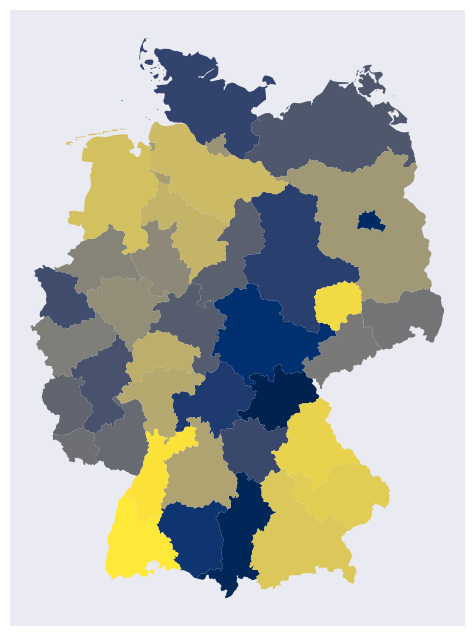

In [105]:
fig = plt.figure(figsize = (14,8))
ax = fig.subplots(1)

shape_de.plot(cmap = 'cividis', ax = ax)
plt.xticks([])
plt.yticks([])

for _, spine in ax.spines.items():
    spine.set_visible(False)
plt.show()

In [106]:
spatial_pattern.head(2)

NUTS2   com_MWsum   ind_MWsum  mob_MWsum   res_MWsum         sum name_NUTS2
0  DE11 14163205.46 46982471.62 6804419.93 28728685.94 96678782.95   Stuggart
1  DE12  9171159.64 25456051.65 4675925.28 19887442.16 59190578.73  Karlsruhe

In [107]:
cdf1_c.set_index('utc_timestamp', inplace=True)
cdf2.set_index('utc_timestamp', inplace=True)
cdf3.set_index('utc_timestamp', inplace=True)
cdf4.set_index('utc_timestamp', inplace=True)
cdf5.set_index('utc_timestamp', inplace=True)
cdf6.set_index('utc_timestamp', inplace=True)
cdf7.set_index('utc_timestamp', inplace=True)
cdf8.set_index('utc_timestamp', inplace=True)


In [108]:
cdf1_c.head(2)

DE11     DE12     DE13     DE14     DE21  \
utc_timestamp                                                            
2019-01-01 00:00:00+01:00 50619.26 32687.67 28149.85 24891.88 70020.61   
2019-01-01 01:00:00+01:00 45620.08 29459.42 25369.76 22433.55 63105.35   

                              DE22     DE23     DE24     DE25     DE26  ...  \
utc_timestamp                                                           ...   
2019-01-01 00:00:00+01:00 19863.05 16180.25 13536.05 23609.58 17312.01  ...   
2019-01-01 01:00:00+01:00 17901.37 14582.29 12199.22 21277.89 15602.27  ...   

                              DEB1    DEB2     DEB3     DEC0     DED2  \
utc_timestamp                                                           
2019-01-01 00:00:00+01:00 17874.80 7762.47 28229.93 10734.45 19775.33   
2019-01-01 01:00:00+01:00 16109.48 6995.84 25441.93  9674.32 17822.31   

                              DED4     DED5     DEE0     DEF0     DEG0  
utc_timestamp                                                           
2019-01-01 00:00:00+01:00 16494.56 13073.19 27797.27 40871.31 26345.95  
2019-01-01 01:00:00+01:00 14865.56 11782.08 25052.01 36834.85 23744.01  

[2 rows x 38 columns]

In [109]:
com_spa_tem = ((((((cdf1_c.T.add(cdf2.T)).add(cdf3.T)).add(cdf4.T)).\
                add(cdf5.T)).add(cdf6.T)).add(cdf7.T)).add(cdf8.T)

com_spa_tem.head(2)

utc_timestamp  2019-01-01 00:00:00+01:00  2019-01-01 01:00:00+01:00  \
DE11                          1053620.47                  937402.39   
DE12                           652810.40                  586050.11   

utc_timestamp  2019-01-01 02:00:00+01:00  2019-01-01 03:00:00+01:00  \
DE11                           814214.18                  730366.70   
DE12                           513032.96                  460201.02   

utc_timestamp  2019-01-01 04:00:00+01:00  2019-01-01 05:00:00+01:00  \
DE11                           712916.24                  734973.41   
DE12                           450084.32                  465964.47   

utc_timestamp  2019-01-01 06:00:00+01:00  2019-01-01 07:00:00+01:00  \
DE11                           822432.29                  880079.45   
DE12                           522582.19                  566780.90   

utc_timestamp  2019-01-01 08:00:00+01:00  2019-01-01 09:00:00+01:00  ...  \
DE11                           845064.14                  898290.56  ...   
DE12                           548383.81                  579137.85  ...   

utc_timestamp  2019-12-31 14:00:00+01:00  2019-12-31 15:00:00+01:00  \
DE11                          3073041.43                 3313081.65   
DE12                          1816746.23                 2013901.60   

utc_timestamp  2019-12-31 16:00:00+01:00  2019-12-31 17:00:00+01:00  \
DE11                          3599247.60                 3688492.00   
DE12                          2186884.47                 2247048.46   

utc_timestamp  2019-12-31 18:00:00+01:00  2019-12-31 19:00:00+01:00  \
DE11                          3294522.72                 2290918.72   
DE12                          2019238.41                 1382326.56   

utc_timestamp  2019-12-31 20:00:00+01:00  2019-12-31 21:00:00+01:00  \
DE11                          1787641.41                 1570628.78   
DE12                          1074914.55                  940778.88   

utc_timestamp  2019-12-31 22:00:00+01:00  2019-12-31 23:00:00+01:00  
DE11                          1384095.35                 1288125.75  
DE12                           836789.51                  785530.52  

[2 rows x 8760 columns]

In [110]:
idf1_c.set_index('utc_timestamp', inplace=True)
idf2.set_index('utc_timestamp', inplace=True)
idf3.set_index('utc_timestamp', inplace=True)
idf4.set_index('utc_timestamp', inplace=True)
idf5.set_index('utc_timestamp', inplace=True)
idf6.set_index('utc_timestamp', inplace=True)
idf7.set_index('utc_timestamp', inplace=True)
idf8.set_index('utc_timestamp', inplace=True)


In [111]:
ind_spa_tem = ((((((idf1_c.T.add(idf2.T)).add(idf3.T)).add(idf4.T)).\
                add(idf5.T)).add(idf6.T)).add(idf7.T)).add(idf8.T)

ind_spa_tem.head(2)

utc_timestamp  2019-01-01 00:00:00+01:00  2019-01-01 01:00:00+01:00  \
DE11                          3630365.28                 3519827.81   
DE12                          1995247.31                 1959494.77   

utc_timestamp  2019-01-01 02:00:00+01:00  2019-01-01 03:00:00+01:00  \
DE11                          3451412.43                 3387385.50   
DE12                          1928800.84                 1898583.45   

utc_timestamp  2019-01-01 04:00:00+01:00  2019-01-01 05:00:00+01:00  \
DE11                          3516030.69                 3645434.16   
DE12                          1933693.61                 1969777.99   

utc_timestamp  2019-01-01 06:00:00+01:00  2019-01-01 07:00:00+01:00  \
DE11                          3774891.19                 3949723.74   
DE12                          2005425.85                 2066489.04   

utc_timestamp  2019-01-01 08:00:00+01:00  2019-01-01 09:00:00+01:00  ...  \
DE11                          4124556.30                 4055336.39  ...   
DE12                          2126202.72                 2119584.14  ...   

utc_timestamp  2019-12-31 14:00:00+01:00  2019-12-31 15:00:00+01:00  \
DE11                          6888922.46                 6739937.51   
DE12                          3660851.69                 3590660.21   

utc_timestamp  2019-12-31 16:00:00+01:00  2019-12-31 17:00:00+01:00  \
DE11                          6598708.31                 6420092.03   
DE12                          3501531.92                 3405127.51   

utc_timestamp  2019-12-31 18:00:00+01:00  2019-12-31 19:00:00+01:00  \
DE11                          6243566.91                 6041649.93   
DE12                          3302933.21                 3182007.99   

utc_timestamp  2019-12-31 20:00:00+01:00  2019-12-31 21:00:00+01:00  \
DE11                          5859320.13                 5672227.96   
DE12                          3088030.94                 3001240.38   

utc_timestamp  2019-12-31 22:00:00+01:00  2019-12-31 23:00:00+01:00  
DE11                          5467460.10                 5292299.04  
DE12                          2907097.91                 2831449.13  

[2 rows x 8760 columns]

In [112]:
mdf1_c.set_index('utc_timestamp', inplace=True)

In [113]:
mob_spa_tem = mdf1_c.T #just analysis on 1 profile of mechanical

mob_spa_tem.head(2)

utc_timestamp  2019-01-01 00:00:00+01:00  2019-01-01 01:00:00+01:00  \
DE11                           192635.66                  155427.13   
DE12                           125565.07                  101153.35   

utc_timestamp  2019-01-01 02:00:00+01:00  2019-01-01 03:00:00+01:00  \
DE11                           163371.05                   91775.43   
DE12                           106279.05                   60047.52   

utc_timestamp  2019-01-01 04:00:00+01:00  2019-01-01 05:00:00+01:00  \
DE11                            74155.71                   95781.62   
DE12                            48735.14                   62596.95   

utc_timestamp  2019-01-01 06:00:00+01:00  2019-01-01 07:00:00+01:00  \
DE11                            62262.96                   58930.94   
DE12                            41143.32                   39126.15   

utc_timestamp  2019-01-01 08:00:00+01:00  2019-01-01 09:00:00+01:00  ...  \
DE11                            58347.03                  163695.18  ...   
DE12                            38903.02                  107157.11  ...   

utc_timestamp  2019-12-31 14:00:00+01:00  2019-12-31 15:00:00+01:00  \
DE11                           722713.49                  686898.98   
DE12                           468165.32                  445446.06   

utc_timestamp  2019-12-31 16:00:00+01:00  2019-12-31 17:00:00+01:00  \
DE11                           817822.59                  720496.82   
DE12                           529956.99                  466950.18   

utc_timestamp  2019-12-31 18:00:00+01:00  2019-12-31 19:00:00+01:00  \
DE11                           579020.60                  328566.03   
DE12                           375284.53                  213840.39   

utc_timestamp  2019-12-31 20:00:00+01:00  2019-12-31 21:00:00+01:00  \
DE11                           173562.54                  181943.35   
DE12                           113519.43                  118764.12   

utc_timestamp  2019-12-31 22:00:00+01:00  2019-12-31 23:00:00+01:00  
DE11                           107405.59                   69692.45  
DE12                            70676.82                   46255.60  

[2 rows x 8760 columns]

In [114]:
rdf1_c.set_index('utc_timestamp', inplace=True)
rdf2.set_index('utc_timestamp', inplace=True)
rdf3.set_index('utc_timestamp', inplace=True)
rdf4.set_index('utc_timestamp', inplace=True)
rdf5.set_index('utc_timestamp', inplace=True)
rdf6.set_index('utc_timestamp', inplace=True)
rdf7.set_index('utc_timestamp', inplace=True)
rdf8.set_index('utc_timestamp', inplace=True)

In [115]:
res_spa_tem = ((((((rdf1_c.T.add(rdf2.T)).add(rdf3.T)).add(rdf4.T)).\
                add(rdf5.T)).add(rdf6.T)).add(rdf7.T)).add(rdf8.T)

res_spa_tem.head(2)

utc_timestamp  2019-01-01 00:00:00+01:00  2019-01-01 01:00:00+01:00  \
DE11                          3492296.53                 3517547.54   
DE12                          2488213.90                 2505537.34   

utc_timestamp  2019-01-01 02:00:00+01:00  2019-01-01 03:00:00+01:00  \
DE11                          3735434.79                 3714816.37   
DE12                          2676902.71                 2681375.63   

utc_timestamp  2019-01-01 04:00:00+01:00  2019-01-01 05:00:00+01:00  \
DE11                          3634081.41                 3657159.29   
DE12                          2599626.64                 2620125.24   

utc_timestamp  2019-01-01 06:00:00+01:00  2019-01-01 07:00:00+01:00  \
DE11                          3781691.17                 4234656.21   
DE12                          2705257.17                 2958621.24   

utc_timestamp  2019-01-01 08:00:00+01:00  2019-01-01 09:00:00+01:00  ...  \
DE11                          6061403.42                 7808170.70  ...   
DE12                          4232661.08                 5499633.10  ...   

utc_timestamp  2019-12-31 14:00:00+01:00  2019-12-31 15:00:00+01:00  \
DE11                          4920836.80                 5534580.94   
DE12                          3469475.80                 3790852.96   

utc_timestamp  2019-12-31 16:00:00+01:00  2019-12-31 17:00:00+01:00  \
DE11                          5843694.18                 6686340.99   
DE12                          4169859.41                 4931593.47   

utc_timestamp  2019-12-31 18:00:00+01:00  2019-12-31 19:00:00+01:00  \
DE11                          7829386.95                 7229529.38   
DE12                          5251488.73                 4924207.82   

utc_timestamp  2019-12-31 20:00:00+01:00  2019-12-31 21:00:00+01:00  \
DE11                          5783539.30                 5207238.38   
DE12                          4114645.81                 3753484.42   

utc_timestamp  2019-12-31 22:00:00+01:00  2019-12-31 23:00:00+01:00  
DE11                          5537852.46                 5399603.09  
DE12                          3821660.59                 3583119.32  

[2 rows x 8760 columns]

In [116]:
total_spa_tem = ((com_spa_tem.add(ind_spa_tem)).add(mob_spa_tem)).add(res_spa_tem)

total_spa_tem.head(2)

utc_timestamp  2019-01-01 00:00:00+01:00  2019-01-01 01:00:00+01:00  \
DE11                          8368917.94                 8130204.87   
DE12                          5261836.68                 5152235.57   

utc_timestamp  2019-01-01 02:00:00+01:00  2019-01-01 03:00:00+01:00  \
DE11                          8164432.45                 7924344.00   
DE12                          5225015.56                 5100207.62   

utc_timestamp  2019-01-01 04:00:00+01:00  2019-01-01 05:00:00+01:00  \
DE11                          7937184.05                 8133348.48   
DE12                          5032139.71                 5118464.65   

utc_timestamp  2019-01-01 06:00:00+01:00  2019-01-01 07:00:00+01:00  \
DE11                          8441277.61                 9123390.34   
DE12                          5274408.53                 5631017.33   

utc_timestamp  2019-01-01 08:00:00+01:00  2019-01-01 09:00:00+01:00  ...  \
DE11                         11089370.89                12925492.83  ...   
DE12                          6946150.63                 8305512.20  ...   

utc_timestamp  2019-12-31 14:00:00+01:00  2019-12-31 15:00:00+01:00  \
DE11                         15605514.18                16274499.08   
DE12                          9415239.04                 9840860.83   

utc_timestamp  2019-12-31 16:00:00+01:00  2019-12-31 17:00:00+01:00  \
DE11                         16859472.68                17515421.84   
DE12                         10388232.79                11050719.62   

utc_timestamp  2019-12-31 18:00:00+01:00  2019-12-31 19:00:00+01:00  \
DE11                         17946497.18                15890664.06   
DE12                         10948944.88                 9702382.76   

utc_timestamp  2019-12-31 20:00:00+01:00  2019-12-31 21:00:00+01:00  \
DE11                         13604063.38                12632038.47   
DE12                          8391110.73                 7814267.80   

utc_timestamp  2019-12-31 22:00:00+01:00  2019-12-31 23:00:00+01:00  
DE11                         12496813.50                12049720.33  
DE12                          7636224.83                 7246354.57  

[2 rows x 8760 columns]

In [117]:
shape_de.head(2)

NUTS_ID  LEVL_CODE CNTR_CODE    NAME_LATN    NUTS_NAME  MOUNT_TYPE  \
89     DE24          2        DE  Oberfranken  Oberfranken        0.00   
129    DE27          2        DE     Schwaben     Schwaben        0.00   

     URBN_TYPE  COAST_TYPE   FID  \
89           0           0  DE24   
129          0           0  DE27   

                                              geometry  
89   POLYGON ((11.48157 50.43162, 11.48290 50.40161...  
129  POLYGON ((10.64226 49.01663, 10.63559 48.98949...

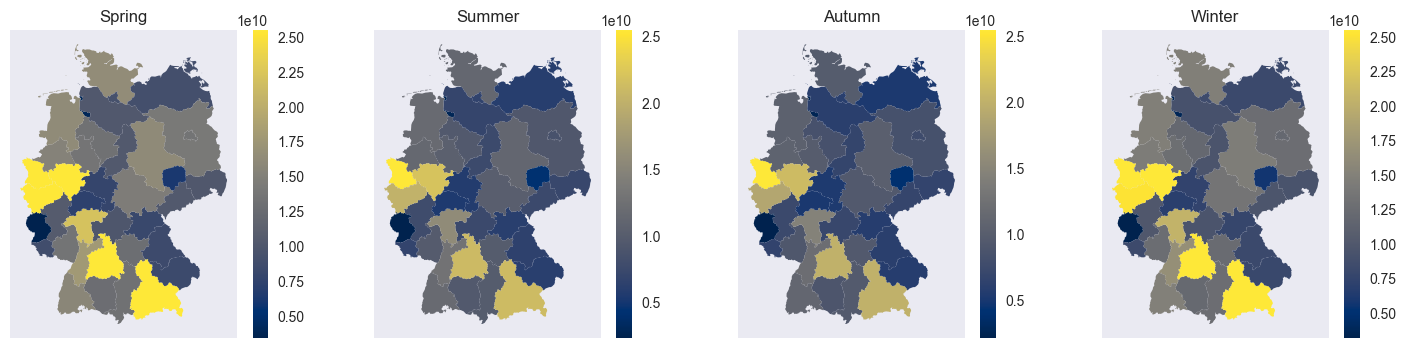

In [118]:
fig = plt.figure(figsize = (18,4))
season = np.array([0, 90, 181, 273, 365])
total = total_spa_tem.values

for t in range (4):
    df = pd.DataFrame({'NUTS_ID': list(total_spa_tem.T.columns), 
                       'total': np.sum(total[:, season[t]*24 : season[t+1] * 24], 
                                       axis=1).reshape(-1)})
    shape_val = shape_de.set_index('NUTS_ID').join (df.set_index('NUTS_ID'))    

    shape_val = shape_val.reset_index()
    ax = fig.add_subplot(1,4, t+1)
    shape_val.plot('total', cmap = 'cividis', 
                   legend = True, vmax = 25.5e9, ax = ax)
                   
    plt.xticks([])
    plt.yticks([])
    
    if t==0:
        plt.title('Spring')
    elif t==1:
        plt.title('Summer')
    elif t==2:
        plt.title('Autumn')
    elif t==3:
        plt.title('Winter')
    for _, spine in ax.spines.items():
        spine.set_visible(False)
plt.show()

It is clearly that the pattern of energy consumption changes over a year. However, there are some regions consuming much energy even during summer and autumn. Their energy consumption patterns change lightly over 4 seasons.

In [119]:
total=spatial_pattern.iloc[:,1:5].sum(axis=0)
total = pd.DataFrame(total).reset_index()
total.columns = ['Sector','Consumption']
total

Sector  Consumption
0  com_MWsum 304135472.85
1  ind_MWsum 700235780.96
2  mob_MWsum 157337373.13
3  res_MWsum 618786111.15

In [120]:
total1=total.set_index('Sector').sort_values(by = 'Consumption', ascending=False)

<AxesSubplot:ylabel='Sector'>

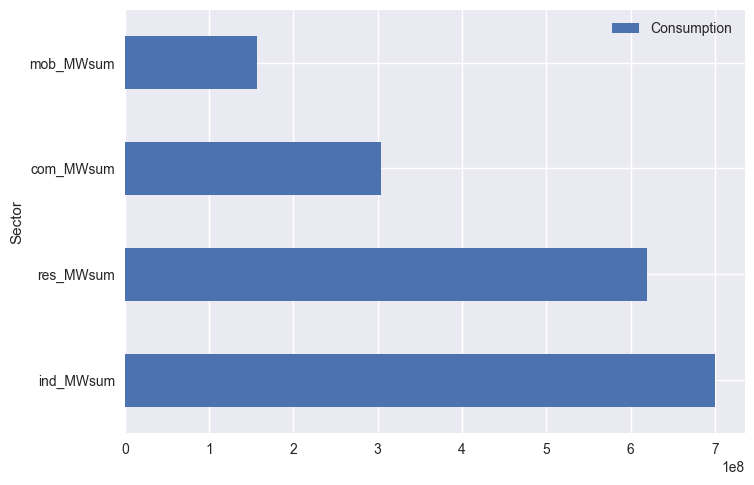

In [121]:
total1.plot(kind = 'barh')

In [122]:
#!pip install pywaffle

In [ ]:
from pywaffle import Waffle


In [ ]:
total1['percent'] = round((total1['Consumption']/total1['Consumption'].sum())*100,0)
total1

In [ ]:
dict_sum = {'Industrial':39,'Residential':35,'Commerce':17,'Mobility':9}

In [ ]:
fig = plt.figure(FigureClass=Waffle,
                 figsize=(9,7),
                 values=dict_sum, 
                 columns=14,
                 vertical=True,
                 starting_location='NW',
                 block_arranging_style='new-line',                 
               colors=['#FED833', '#FA7711', '#65713F', '#192B33'],
                 icons=['industry','house','building','car'],                                
                font_size=20,
                 icon_legend=True,
                legend={'bbox_to_anchor':(1.1,1),
                       'fontsize':10,'frameon':False})
plt.title('SECTORAL SHARE OF ENERGY CONSUMPTION', fontsize=25)
fig.text(x=-0.115, y=0.825, s='Industrial', fontsize=15)
fig.text(x=-0.127, y=0.558, s='Residential', fontsize=15)
fig.text(x=-0.125, y=0.282, s='Commerce', fontsize=15)
fig.text(x=-0.099, y=0.109, s='Mobility', fontsize=15)
plt.legend([])
plt.show

Sectorially, industry and commerce consume the most energy.


## Saving 3 datasets 

In [ ]:
#Temporal setors
total_pattern.head(2)

In [ ]:
#total_pattern.to_csv('tem_sec.csv') #temporal and sectors distribution of energy consumption

In [ ]:
#Spatial sectors
spatial_pattern.head(2)

In [ ]:
#spatial_pattern.to_csv('spa_sec.csv')#spatial and sector distribution of energy consumption

In [ ]:
#Spatial-temporal
total_spa_tem.head(2)

In [ ]:
#total_spa_tem.to_csv('spa_tem.csv')#spatial and temporial distribution of energy consumption

# Linear regression 

In [123]:
temp.head(2)

dates  month  day  hour  DE11  DE12  DE13  DE14  DE21  DE22  \
0 2019-01-01 00:00:00      1    1     0  1.46  1.36  1.36  1.46  1.46  1.46   
1 2019-01-01 01:00:00      1    1     1  1.43  1.35  1.35  1.43  1.43  1.43   

   ...  DEB1  DEB2  DEB3  DEC0  DED2  DED4  DED5  DEE0  DEF0  DEG0  
0  ...  1.54  1.36  1.54  1.54  1.31  1.31  1.31  1.31  1.62  1.67  
1  ...  1.57  1.35  1.57  1.57  1.35  1.35  1.35  1.35  1.66  1.72  

[2 rows x 42 columns]

In [124]:
temp_cl = temp.iloc[:,4:]
temp_cl = temp_cl.T.reset_index(False)
temp_cl['temp_mean']=temp_cl.iloc[:,1:].mean()
temp_cl.drop(temp_cl.iloc[:,1:-1].columns, axis=1, inplace=True)
temp_cl.rename(columns={'index':'NUTS2'}, inplace=True)
temp_cl.head(2)

NUTS2  temp_mean
0  DE11       1.47
1  DE12       1.49

In [125]:
temp_cl.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38 entries, 0 to 37
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   NUTS2      38 non-null     object 
 1   temp_mean  38 non-null     float64
dtypes: float64(1), object(1)
memory usage: 736.0+ bytes


In [126]:
spatial_pattern.head(2)

NUTS2   com_MWsum   ind_MWsum  mob_MWsum   res_MWsum         sum name_NUTS2
0  DE11 14163205.46 46982471.62 6804419.93 28728685.94 96678782.95   Stuggart
1  DE12  9171159.64 25456051.65 4675925.28 19887442.16 59190578.73  Karlsruhe

In [127]:
df = spatial_pattern
df['temp_mean'] = temp_cl['temp_mean']


In [130]:
pop = pd.read_csv('./Dataset/demo_gpd_NUTS2.csv')
pop.head(2)

geo  TIME_PERIOD  population     unit geo.1  TIME_PERIOD.1  gdp_mio_euro  \
0  DE11         2019     4143418  MIO_EUR  DE11           2019     224632.72   
1  DE12         2019     2805129  MIO_EUR  DE12           2019     128174.58   

   gdp_per_capita  
0        54214.35  
1        45692.94

In [131]:
df[['population','gdp_mio_euro','gdp_per_capita']] = pop[['population','gdp_mio_euro','gdp_per_capita']]

In [132]:
df.columns

Index(['NUTS2', 'com_MWsum', 'ind_MWsum', 'mob_MWsum', 'res_MWsum', 'sum',
       'name_NUTS2', 'temp_mean', 'population', 'gdp_mio_euro',
       'gdp_per_capita'],
      dtype='object')

In [133]:
df = df[['NUTS2','name_NUTS2','com_MWsum', 'ind_MWsum', 'mob_MWsum',
       'res_MWsum', 'sum', 'temp_mean','population', 'gdp_mio_euro', 'gdp_per_capita']] 

In [134]:
df.head(2)

NUTS2 name_NUTS2   com_MWsum   ind_MWsum  mob_MWsum   res_MWsum         sum  \
0  DE11   Stuggart 14163205.46 46982471.62 6804419.93 28728685.94 96678782.95   
1  DE12  Karlsruhe  9171159.64 25456051.65 4675925.28 19887442.16 59190578.73   

   temp_mean  population  gdp_mio_euro  gdp_per_capita  
0       1.47     4143418     224632.72        54214.35  
1       1.49     2805129     128174.58        45692.94

In [135]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38 entries, 0 to 37
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   NUTS2           38 non-null     object 
 1   name_NUTS2      38 non-null     object 
 2   com_MWsum       38 non-null     float64
 3   ind_MWsum       38 non-null     float64
 4   mob_MWsum       38 non-null     float64
 5   res_MWsum       38 non-null     float64
 6   sum             38 non-null     float64
 7   temp_mean       38 non-null     float64
 8   population      38 non-null     int64  
 9   gdp_mio_euro    38 non-null     float64
 10  gdp_per_capita  38 non-null     float64
dtypes: float64(8), int64(1), object(2)
memory usage: 3.4+ KB


In [136]:
df.describe()

com_MWsum   ind_MWsum  mob_MWsum   res_MWsum          sum  temp_mean  \
count       38.00       38.00      38.00       38.00        38.00      38.00   
mean   8003565.07 18427257.39 4140457.19 16283845.03  46855124.69       1.50   
std    4264402.20 13348329.22 2038212.59  7599256.66  25749089.94       0.03   
min    2177911.14  3686046.62  925654.91  4210580.05  11030470.86       1.45   
25%    4889419.61 10908036.56 2730081.44 11122682.82  30229359.77       1.47   
50%    7267555.20 14043258.91 3720687.42 14253791.60  43172953.14       1.49   
75%    9431916.45 20014586.97 4794518.17 18841120.57  52218477.12       1.51   
max   19591680.49 65859070.38 9588114.16 36752010.05 130315215.20       1.55   

       population  gdp_mio_euro  gdp_per_capita  
count       38.00         38.00           38.00  
mean   2184716.13      91403.95        40212.64  
std    1161378.20      62743.94         8821.10  
min     531007.00      16703.89        29197.11  
25%    1346954.25      48680.55        34377.31  
50%    1872135.50      78443.17        39507.44  
75%    2599047.50      97824.63        44010.89  
max    5202321.00     284856.66        67411.34

In [137]:
df['sum'].describe()

count          38.00
mean     46855124.69
std      25749089.94
min      11030470.86
25%      30229359.77
50%      43172953.14
75%      52218477.12
max     130315215.20
Name: sum, dtype: float64

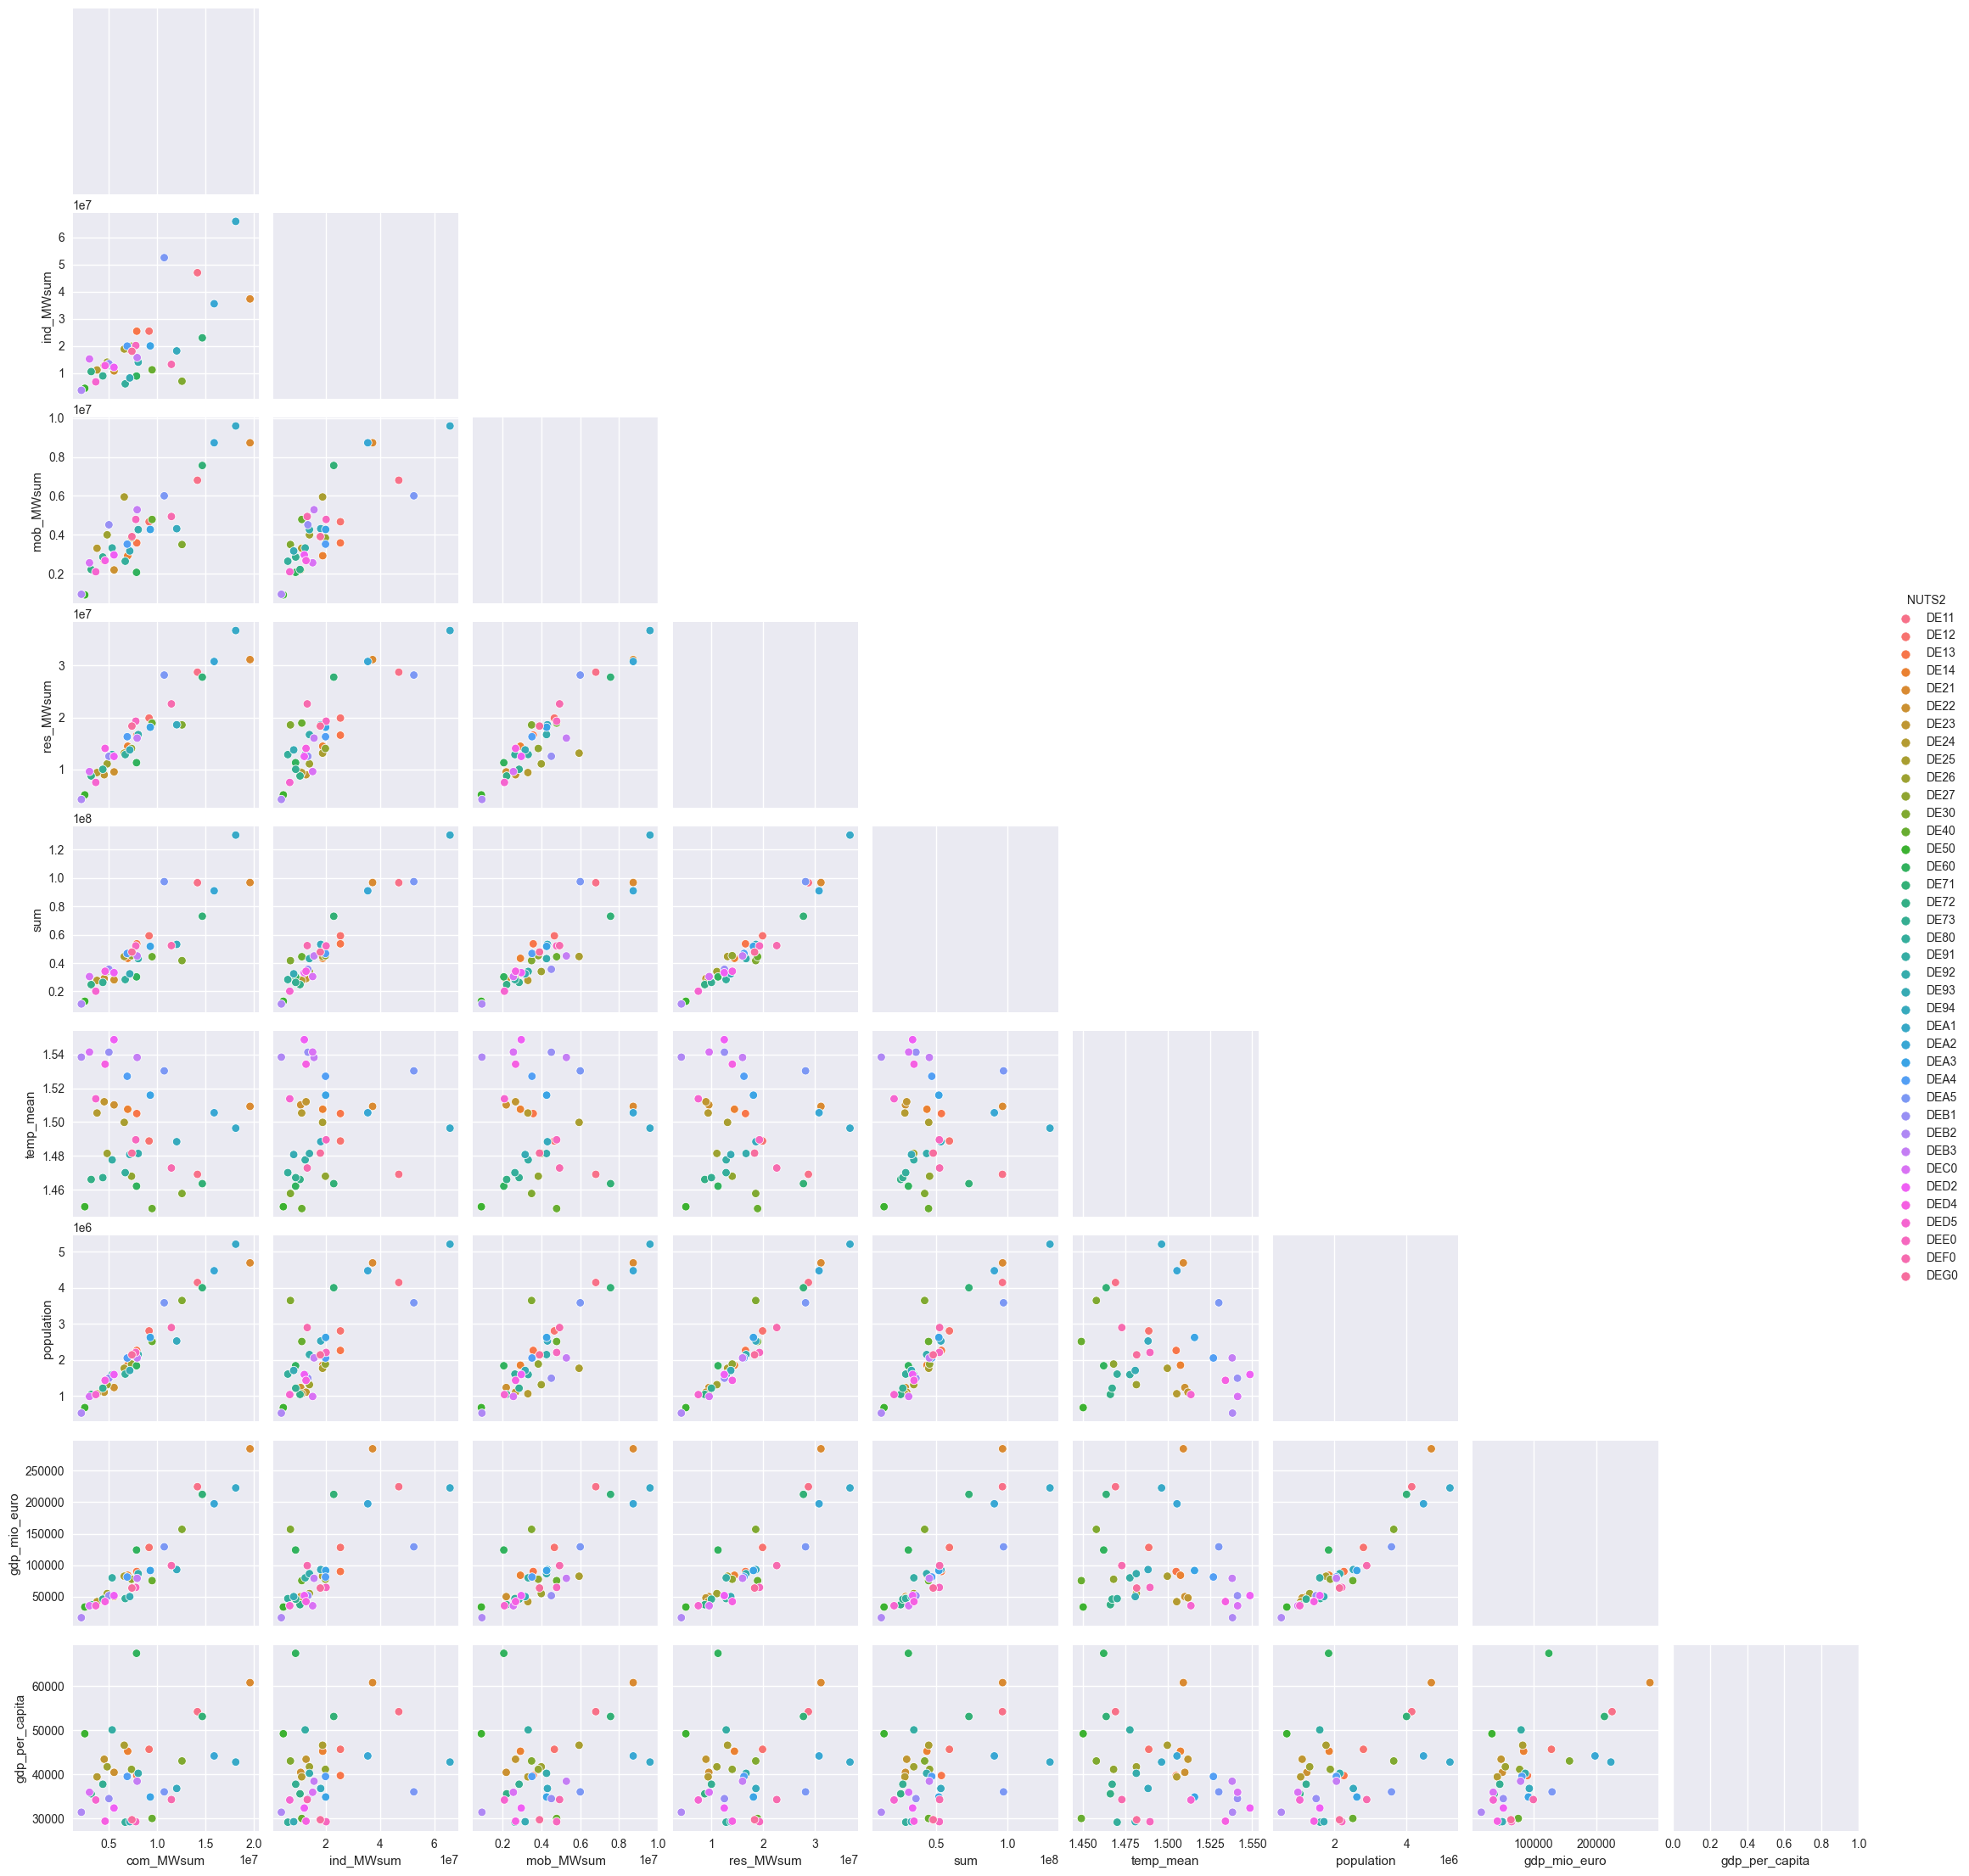

In [138]:
sns.pairplot(df, hue='NUTS2', corner=True)

<AxesSubplot:>

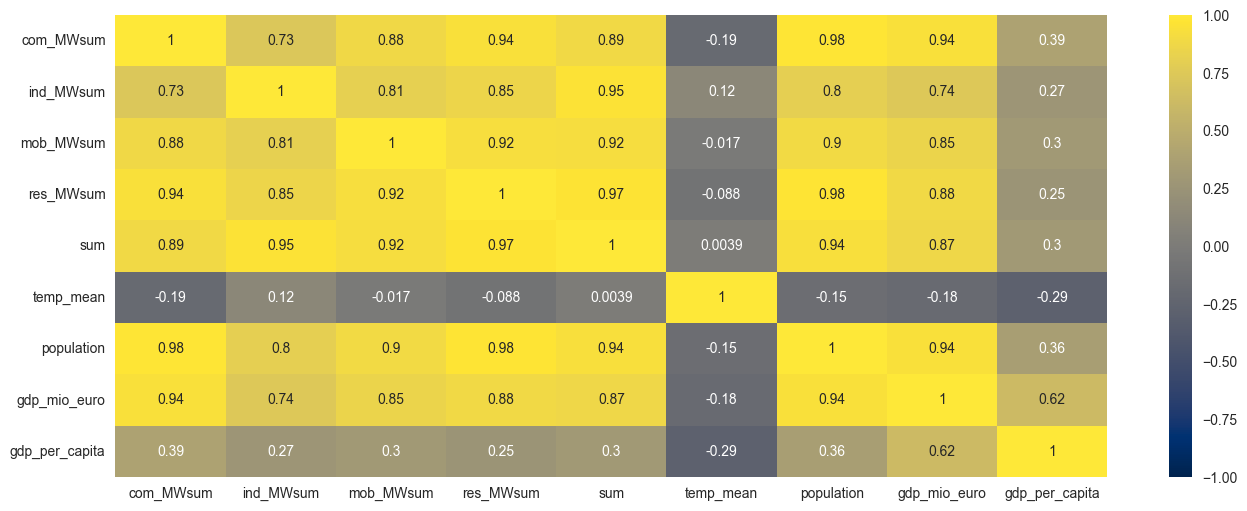

In [139]:
corr = df.corr()

plt.figure(figsize = (16,6))
sns.heatmap(corr, vmin=-1, vmax=1, annot=True, cmap='cividis')

Temperature is an important factor influencing energy consumption pattern. It varies hourly, daily, monthly. But when calcuting the sum of energy consumption annually, mean of temperature can't show the correlation with sum of energy consumption.<br>

It is rather obviously that sum of energy consumption has correlation with population and gdp, gdp per capita. We should build regression model for each sectors (commerce, residential, mobility, industry). Here I just give a representative of the whole.

In [140]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38 entries, 0 to 37
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   NUTS2           38 non-null     object 
 1   name_NUTS2      38 non-null     object 
 2   com_MWsum       38 non-null     float64
 3   ind_MWsum       38 non-null     float64
 4   mob_MWsum       38 non-null     float64
 5   res_MWsum       38 non-null     float64
 6   sum             38 non-null     float64
 7   temp_mean       38 non-null     float64
 8   population      38 non-null     int64  
 9   gdp_mio_euro    38 non-null     float64
 10  gdp_per_capita  38 non-null     float64
dtypes: float64(8), int64(1), object(2)
memory usage: 3.4+ KB


In [141]:
df.columns

Index(['NUTS2', 'name_NUTS2', 'com_MWsum', 'ind_MWsum', 'mob_MWsum',
       'res_MWsum', 'sum', 'temp_mean', 'population', 'gdp_mio_euro',
       'gdp_per_capita'],
      dtype='object')

In [142]:
X = df[['population', 'gdp_mio_euro','gdp_per_capita', 'temp_mean']]

y = df['sum']

In [143]:
X.shape

(38, 4)

In [144]:
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size = 0.3, 
                                                    random_state = 7)

In [145]:
lm = LinearRegression()

In [146]:
lm.fit(X_train, y_train)

LinearRegression()

In [147]:
print('Intercept of the Linear model', lm.intercept_)

Intercept of the Linear model -278536972.86456555


In [148]:
y_pred = lm.predict(X_test)

Text(0, 0.5, 'Predicted sum of energy consumption')

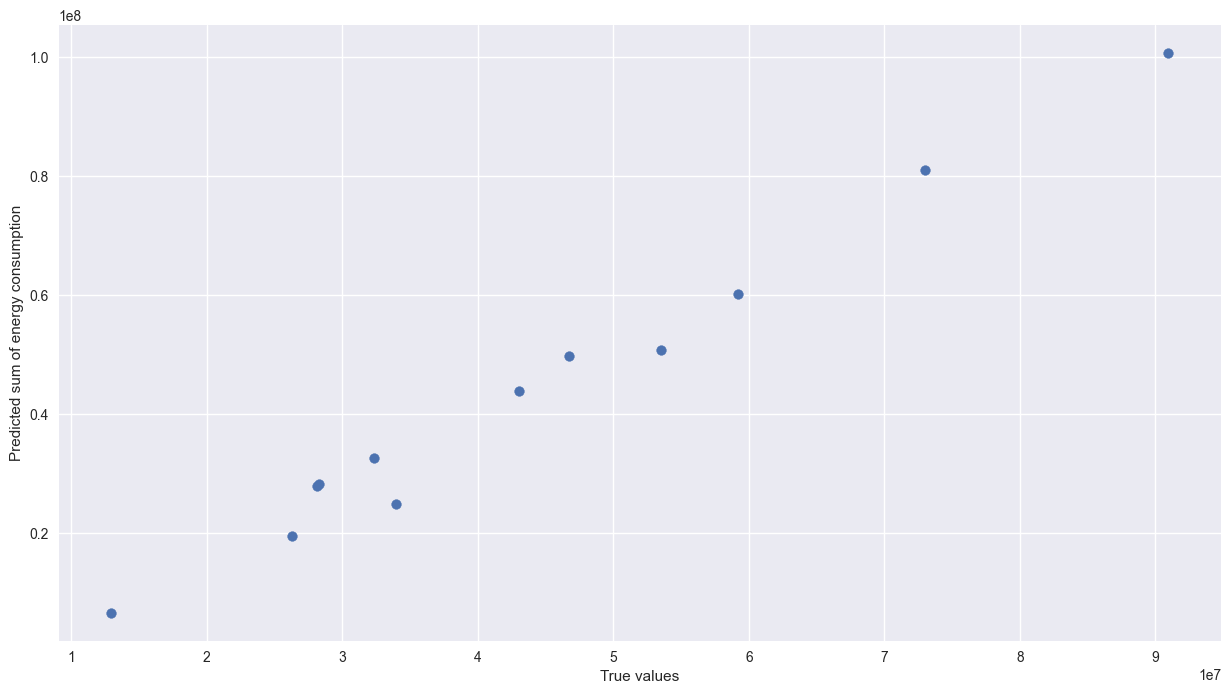

In [149]:
plt.figure(figsize=(15,8))
plt.scatter(y_test,y_pred)

plt.xlabel('True values')
plt.ylabel('Predicted sum of energy consumption')

In [150]:
result = pd.DataFrame({'Real':y_test.ravel(),
                       'Predicted': y_pred.ravel()})
result

Real    Predicted
0  33960893.52  24876268.77
1  59190578.73  60109643.11
2  32349985.50  32537889.08
3  53521575.45  50658835.95
4  12961291.37   6551578.84
5  28273978.27  28167346.80
6  26253325.56  19491136.19
7  43064416.42  43886574.04
8  72992272.26  81017632.29
9  46706975.85  49664805.35
10 90952813.96 100704973.84
11 28099251.39  27903988.43

<AxesSubplot:>

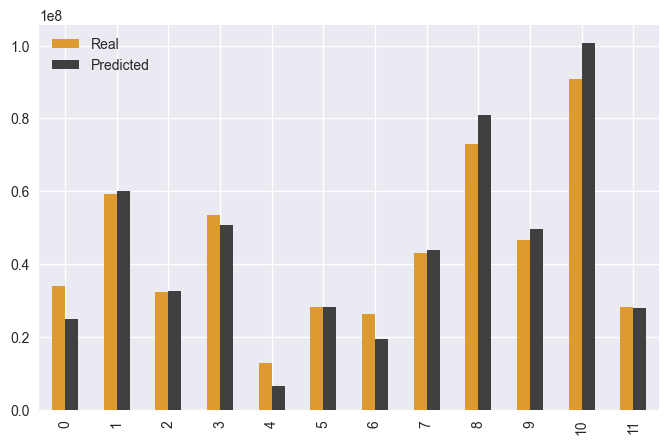

In [151]:
result.plot.bar(figsize=(8,5), color=['#DD9A2E','#404040'])

In [152]:
MAE = mean_absolute_error(y_test, y_pred)
MSE = mean_squared_error(y_test, y_pred)
RMSE = np.sqrt(MSE)
R2 = r2_score(y_test, y_pred)

In [153]:
print('MAE:', MAE)
print('MSE:', MSE)
print('RMSE:', round(RMSE,3))
print('R2 Score:', R2)

MAE: 4007136.298855992
MSE: 28950209472570.91
RMSE: 5380539.887
R2 Score: 0.9355435037557792


# Unsupervised classification

In [154]:
df.head(2)

NUTS2 name_NUTS2   com_MWsum   ind_MWsum  mob_MWsum   res_MWsum         sum  \
0  DE11   Stuggart 14163205.46 46982471.62 6804419.93 28728685.94 96678782.95   
1  DE12  Karlsruhe  9171159.64 25456051.65 4675925.28 19887442.16 59190578.73   

   temp_mean  population  gdp_mio_euro  gdp_per_capita  
0       1.47     4143418     224632.72        54214.35  
1       1.49     2805129     128174.58        45692.94

In [155]:
X = df[['com_MWsum', 'ind_MWsum', 'mob_MWsum',
       'res_MWsum', 'sum', 'temp_mean', 'population', 'gdp_mio_euro',
       'gdp_per_capita']]

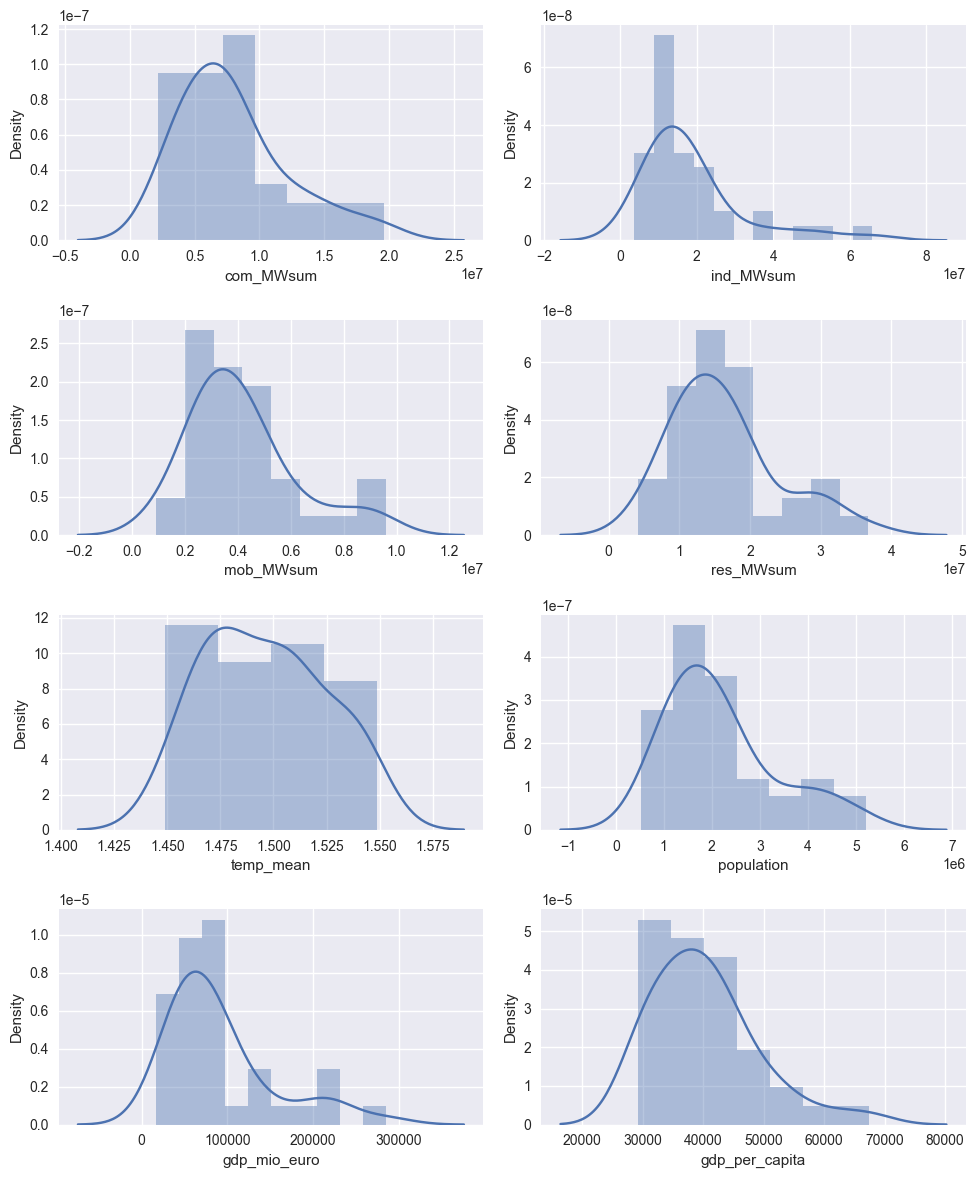

In [156]:
plt.subplots(figsize=(10, 12))

plt.subplot(4, 2, 1);sns.distplot(X['com_MWsum'], label = 'Recency')

plt.subplot(4, 2, 2);sns.distplot(X['ind_MWsum'], label = 'Frequency')

plt.subplot(4, 2, 3);sns.distplot(X['mob_MWsum'], label = 'Monetary Value')

plt.subplot(4, 2, 4);sns.distplot(X['res_MWsum'], label = 'Monetary Value')

plt.subplot(4, 2, 5);sns.distplot(X['temp_mean'], label = 'Monetary Value')

plt.subplot(4, 2, 6);sns.distplot(X['population'], label = 'Monetary Value')

plt.subplot(4, 2, 7);sns.distplot(X['gdp_mio_euro'], label = 'Monetary Value')

plt.subplot(4, 2, 8);sns.distplot(X['gdp_per_capita'], label = 'Monetary Value')

plt.style.use('fivethirtyeight')
plt.tight_layout()
plt.show();

In [157]:
#transform all variables except temperature
X[['com_MWsum', 'ind_MWsum', 'mob_MWsum',
       'res_MWsum', 'sum', 'population', 'gdp_mio_euro',
       'gdp_per_capita']].apply(np.log1p, axis=1)

com_MWsum  ind_MWsum  mob_MWsum  res_MWsum   sum  population  \
0       16.47      17.67      15.73      17.17 18.39       15.24   
1       16.03      17.05      15.36      16.81 17.90       14.85   
2       15.88      17.05      15.09      16.62 17.80       14.63   
3       15.76      16.76      14.89      16.49 17.58       14.43   
4       16.79      17.44      15.98      17.25 18.39       15.36   
5       15.53      16.20      14.61      16.07 17.15       14.03   
6       15.33      16.37      14.80      16.01 17.18       13.92   
7       15.15      16.23      15.01      16.05 17.14       13.88   
8       15.70      16.75      15.60      16.39 17.61       14.39   
9       15.39      16.46      15.20      16.22 17.34       14.09   
10      15.81      16.81      15.16      16.46 17.63       14.45   
11      16.35      15.77      15.07      16.74 17.55       15.11   
12      16.06      16.23      15.38      16.76 17.61       14.74   
13      14.74      15.30      13.74      15.44 16.38       13.43   
14      15.88      16.01      14.55      16.24 17.22       14.43   
15      16.50      16.95      15.84      17.14 18.11       15.20   
16      14.98      16.17      14.62      15.98 17.02       13.86   
17      15.30      16.01      14.87      16.12 17.08       14.01   
18      15.72      15.62      14.79      16.37 17.16       14.29   
19      15.49      16.34      15.02      16.37 17.34       14.28   
20      15.90      16.46      15.27      16.63 17.58       14.58   
21      15.79      15.92      14.97      16.44 17.29       14.35   
22      16.30      16.72      15.28      16.74 17.79       14.74   
23      16.71      18.00      16.08      17.42 18.69       15.46   
24      16.58      17.39      15.98      17.24 18.33       15.31   
25      16.04      16.81      15.27      16.71 17.76       14.78   
26      15.75      16.81      15.08      16.61 17.66       14.54   
27      16.19      17.78      15.61      17.15 18.39       15.09   
28      15.43      16.42      15.32      16.34 17.39       14.22   
29      14.59      15.12      13.77      15.25 16.22       13.18   
30      15.89      16.57      15.48      16.59 17.62       14.54   
31      14.92      16.54      14.76      16.08 17.23       13.81   
32      15.53      16.31      14.91      16.34 17.32       14.28   
33      15.35      16.36      14.80      16.46 17.35       14.18   
34      15.12      15.73      14.56      15.83 16.81       13.86   
35      15.87      16.82      15.38      16.77 17.77       14.61   
36      16.26      16.40      15.41      16.93 17.77       14.88   
37      15.82      16.71      15.18      16.72 17.68       14.58   

    gdp_mio_euro  gdp_per_capita  
0          12.32           10.90  
1          11.76           10.73  
2          11.41           10.59  
3          11.34           10.72  
4          12.56           11.02  
5          10.82           10.61  
6          10.78           10.68  
7          10.65           10.58  
8          11.32           10.75  
9          10.91           10.64  
10         11.26           10.63  
11         11.96           10.67  
12         11.23           10.31  
13         10.42           10.80  
14         11.73           11.12  
15         12.27           10.88  
16         10.53           10.48  
17         10.74           10.54  
18         10.76           10.28  
19         11.29           10.82  
20         11.37           10.60  
21         10.82           10.29  
22         11.44           10.51  
23         12.31           10.66  
24         12.19           10.70  
25         11.42           10.46  
26         11.31           10.59  
27         11.77           10.49  
28         10.85           10.45  
29          9.72           10.36  
30         11.28           10.56  
31         10.48           10.49  
32         10.86           10.39  
33         10.65           10.29  
34         10.48           10.44  
35         11.08           10.29  
36         11.51           10.44  
37         11.06     

In [158]:
#scale data
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

X_scaled = scaler.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled, columns = X.columns)
X_scaled.head(2)

com_MWsum  ind_MWsum  mob_MWsum  res_MWsum  sum  temp_mean  population  \
0       0.69       0.70       0.68       0.75 0.72       0.20        0.77   
1       0.40       0.35       0.43       0.48 0.40       0.40        0.49   

   gdp_mio_euro  gdp_per_capita  
0          0.78            0.65  
1          0.42            0.43

In [159]:
X_scaled.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38 entries, 0 to 37
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   com_MWsum       38 non-null     float64
 1   ind_MWsum       38 non-null     float64
 2   mob_MWsum       38 non-null     float64
 3   res_MWsum       38 non-null     float64
 4   sum             38 non-null     float64
 5   temp_mean       38 non-null     float64
 6   population      38 non-null     float64
 7   gdp_mio_euro    38 non-null     float64
 8   gdp_per_capita  38 non-null     float64
dtypes: float64(9)
memory usage: 2.8 KB


In [160]:
df[df['temp_mean'].isnull()]

Empty DataFrame
Columns: [NUTS2, name_NUTS2, com_MWsum, ind_MWsum, mob_MWsum, res_MWsum, sum, temp_mean, population, gdp_mio_euro, gdp_per_capita]
Index: []

In [161]:
#instantiate model
kmeans = KMeans()
kmeans.fit(X_scaled)
kmeans.inertia_

3.358301906425496

In [162]:
from sklearn.cluster import KMeans
inertia = []

#First : Get the Best KMeans 
ks = range(1,10)

for i in ks:
    kmeans = KMeans(n_clusters= i, random_state=7)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)

In [163]:
inertia

[18.96883579113224,
 9.173091779784567,
 6.72033232672225,
 5.357986979548518,
 4.7854658925217555,
 4.224773839715429,
 3.644091375898314,
 3.049378597069852,
 2.8175021874530177]

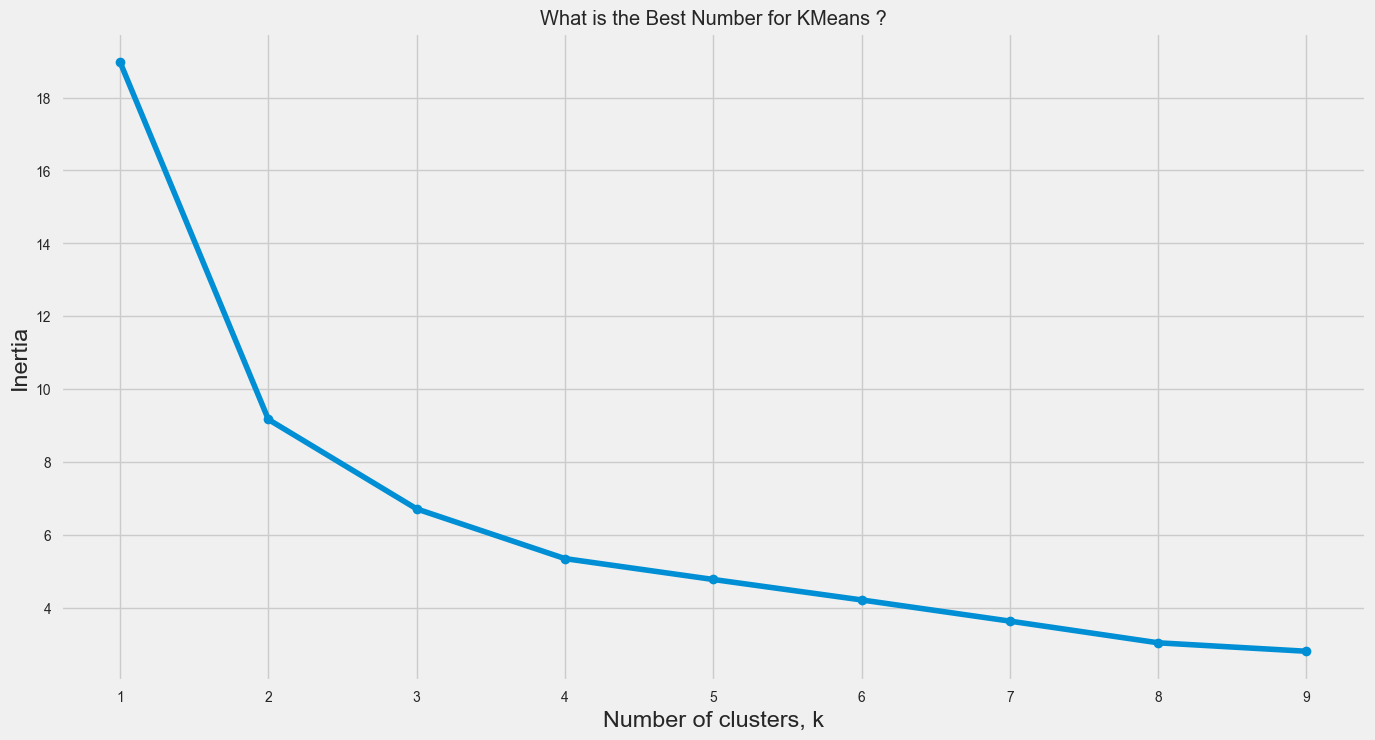

In [164]:
#choose the optimal k - elbow curve
f, ax = plt.subplots(figsize=(15, 8))
plt.plot(ks, inertia, '-o')

plt.xlabel('Number of clusters, k')
plt.ylabel('Inertia')
plt.xticks(ks)
plt.style.use('ggplot')
plt.title('What is the Best Number for KMeans ?')
plt.show()


In [165]:
#choose optimal k by kneed model
from kneed import KneeLocator
kl = KneeLocator(ks, inertia,curve="convex", direction="decreasing")
kl

In [166]:
print('The elbow point of your model is:', kl.elbow)

The elbow point of your model is: 3


In [167]:
#build model with selected k=3
kmeans = KMeans(n_clusters=3, 
                max_iter=100, random_state=9)

kmeans.fit(X_scaled)

KMeans(max_iter=100, n_clusters=3, random_state=9)

In [168]:
kmeans

KMeans(max_iter=100, n_clusters=3, random_state=9)

In [169]:
len(kmeans.labels_)

38

In [170]:
X.head(2)

com_MWsum   ind_MWsum  mob_MWsum   res_MWsum         sum  temp_mean  \
0 14163205.46 46982471.62 6804419.93 28728685.94 96678782.95       1.47   
1  9171159.64 25456051.65 4675925.28 19887442.16 59190578.73       1.49   

   population  gdp_mio_euro  gdp_per_capita  
0     4143418     224632.72        54214.35  
1     2805129     128174.58        45692.94

In [171]:
#assign the label
X_scaled['cluster_id'] = kmeans.labels_
X_scaled['NUTS2'] = df['NUTS2'] 
X_scaled['name_NUTS2'] = df['name_NUTS2']
X_scaled.head(2)

com_MWsum  ind_MWsum  mob_MWsum  res_MWsum  sum  temp_mean  population  \
0       0.69       0.70       0.68       0.75 0.72       0.20        0.77   
1       0.40       0.35       0.43       0.48 0.40       0.40        0.49   

   gdp_mio_euro  gdp_per_capita  cluster_id NUTS2 name_NUTS2  
0          0.78            0.65           1  DE11   Stuggart  
1          0.42            0.43           2  DE12  Karlsruhe

In [172]:
#Visual analysis
def plot_clusters (df, var1, var2):
    """
    Function to plot each pair of variables after clustering
    """
    
    fig = px.scatter(X_scaled, 
                     x = var1, 
                     y = var2, 
                     color = df['cluster_id'], 
                     color_continuous_scale='cividis')
    #fig.update_traces(color='YlOrRd_r')
    fig.show()

In [173]:
plot_clusters (X_scaled, 'temp_mean', 'sum')

In [174]:
plot_clusters (X_scaled, 'population', 'sum')

In [175]:
plot_clusters (X_scaled, 'population', 'gdp_per_capita')

In [176]:
X_scaled.columns

Index(['com_MWsum', 'ind_MWsum', 'mob_MWsum', 'res_MWsum', 'sum', 'temp_mean',
       'population', 'gdp_mio_euro', 'gdp_per_capita', 'cluster_id', 'NUTS2',
       'name_NUTS2'],
      dtype='object')

In [177]:
plot_clusters (X_scaled, 'com_MWsum', 'gdp_mio_euro')

In [178]:
plot_clusters (X_scaled, 'com_MWsum', 'ind_MWsum')

In [179]:
plot_clusters (X_scaled, 'mob_MWsum', 'ind_MWsum')

K-Mean Clustering with 3 Cluster IDs
- Region with cluster Id 1 has low number of population, low gdp per capita, and low energy consumption but high average temperature.
- Region with cluster Id 2 has high number of population, high gpd per capita and high energy consumption.
- Region with Id 3 are the biggest group which consums the least energy, the avergy temperature is low in comparison to cluster Id 2. Some of them have high gdp and high number of population.

In [180]:
X_scaled[X_scaled['cluster_id']==0][['NUTS2','name_NUTS2']]

NUTS2         name_NUTS2
5   DE22       Niederbayern
6   DE23          Oberpfalz
7   DE24        Oberfranken
26  DEA4            Detmold
28  DEB1            Koblenz
29  DEB2              Trier
30  DEB3  Rheinhessen_Plalz
31  DEC0           Saarland
32  DED2            Dresden
33  DED4           Chemnitz
34  DED5            Leipzig

In [181]:
X_scaled[X_scaled['cluster_id']==1][['NUTS2','name_NUTS2']]

NUTS2  name_NUTS2
0   DE11    Stuggart
4   DE21  Oberbayern
15  DE71   Darmstadt
23  DEA1  Düsseldorf
24  DEA2        Köln
27  DEA5     Arnberg

In [182]:
X_scaled[X_scaled['cluster_id']==2][['NUTS2','name_NUTS2']]

NUTS2              name_NUTS2
1   DE12               Karlsruhe
2   DE13                Freiburg
3   DE14                Tübingen
8   DE25           Mittelfranken
9   DE26            Unterfranken
10  DE27                Schwaben
11  DE30                  Berlin
12  DE40             Brandenburg
13  DE50                  Bremen
14  DE60                 Hamburg
16  DE72                  Gießen
17  DE73                  Kassel
18  DE80  Mecklenburg-Vorpommern
19  DE91             Brauschweig
20  DE92                Hannover
21  DE93                Lüneburg
22  DE94               Weser_Ems
25  DEA3                 Münster
35  DEE0          Sachsen-Anhalt
36  DEF0      Schleswig-Holstein
37  DEG0                Thürigen

In [183]:
shape_val.head(2)

NUTS_ID  LEVL_CODE CNTR_CODE    NAME_LATN    NUTS_NAME  MOUNT_TYPE  \
0    DE24          2        DE  Oberfranken  Oberfranken        0.00   
1    DE27          2        DE     Schwaben     Schwaben        0.00   

   URBN_TYPE  COAST_TYPE   FID  \
0          0           0  DE24   
1          0           0  DE27   

                                            geometry          total  
0  POLYGON ((11.48157 50.43162, 11.48290 50.40161...  7746023440.17  
1  POLYGON ((10.64226 49.01663, 10.63559 48.98949... 12602539565.13

In [184]:
shape_val.shape

(38, 11)

In [185]:
shape_val = shape_val.set_index('NUTS_ID').merge(X_scaled.set_index('NUTS2')[['cluster_id']],how='left',left_index=True,right_index=True)


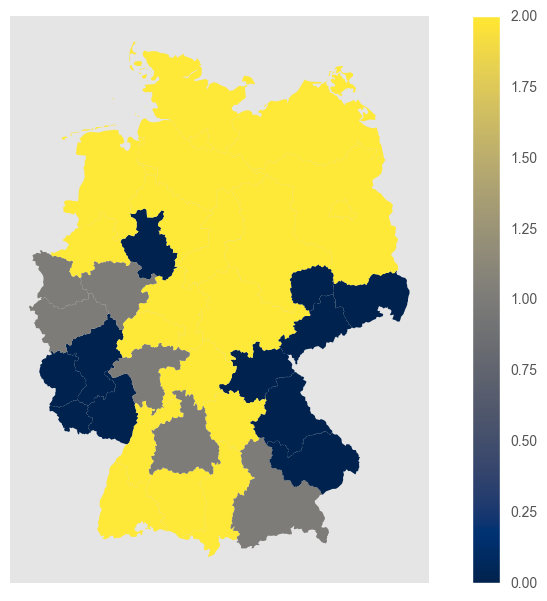

In [186]:
fig = plt.figure(figsize = (10,7))
ax = fig.subplots(1)

shape_val.plot('cluster_id',cmap = 'cividis', ax = ax, legend = True, vmax = 2)
plt.xticks([])
plt.yticks([])

for _, spine in ax.spines.items():
    spine.set_visible(False)
plt.show()



In [187]:
# Bar plots
mean_cluster = X_scaled.groupby('cluster_id').mean().reset_index()
mean_cluster.columns

Index(['cluster_id', 'com_MWsum', 'ind_MWsum', 'mob_MWsum', 'res_MWsum', 'sum',
       'temp_mean', 'population', 'gdp_mio_euro', 'gdp_per_capita'],
      dtype='object')

In [188]:
fig = px.bar(mean_cluster, x = 'cluster_id', y = ['com_MWsum', 'ind_MWsum', 'mob_MWsum', 'res_MWsum'], color_discrete_sequence=['#192b33', '#575d6d', '#a59c74','#dd9a2e', '#fee838'])
#fig.update_layout(barmode='group')
fig.show()

In [189]:
fig = px.bar(mean_cluster, x = 'cluster_id', y = ['sum',
       'temp_mean', 'population', 'gdp_mio_euro', 'gdp_per_capita'], color_discrete_sequence=['#192b33', '#575d6d', '#a59c74','#dd9a2e', '#fee838'])
fig.update_layout(barmode='group')
fig.show()

# Energy capacity & Time series forecoasting

In [190]:
ts = pd.read_csv('./Dataset/time_series_DE.csv')
ts = ts.set_index('utc_timestamp')
ts.index = pd.to_datetime(ts.index)

In [191]:
ts.head(2)

load_consumption(MW)
utc_timestamp                            
2015-01-01 00:00:00                 41151
2015-01-01 01:00:00                 40135

In [192]:
ts.rename(columns = {'load_consumption(MW)':'consumption_MW'}, inplace=True)

<AxesSubplot:title={'center':'Energy Use in Germany'}, xlabel='utc_timestamp'>

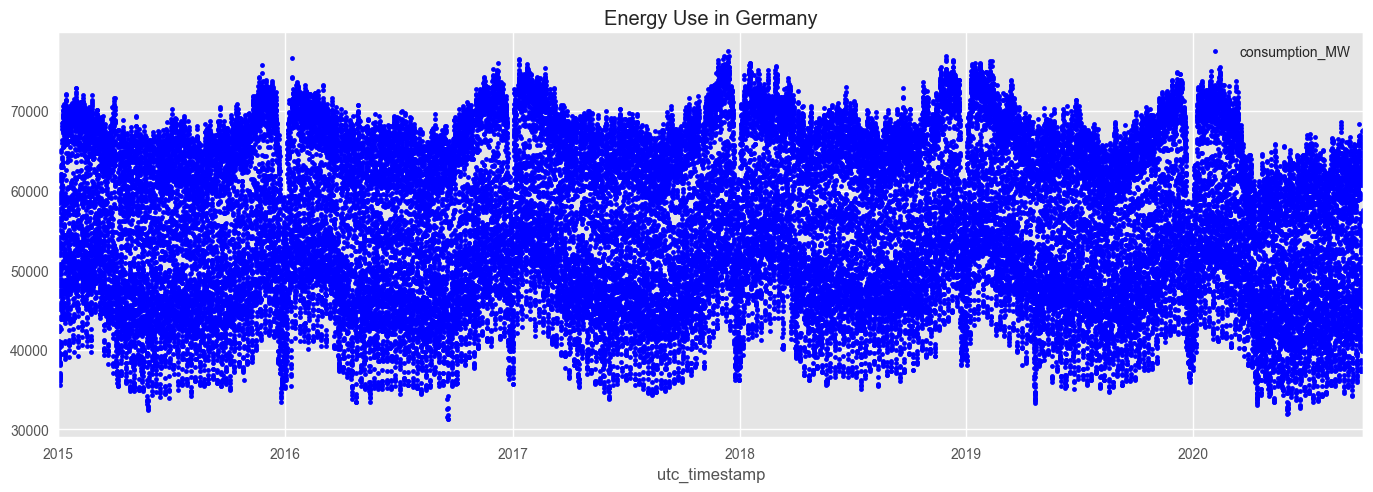

In [193]:
ts.plot (style='.',
         figsize=(15,5),
         color='blue',
         title='Energy Use in Germany')


<AxesSubplot:ylabel='Frequency'>

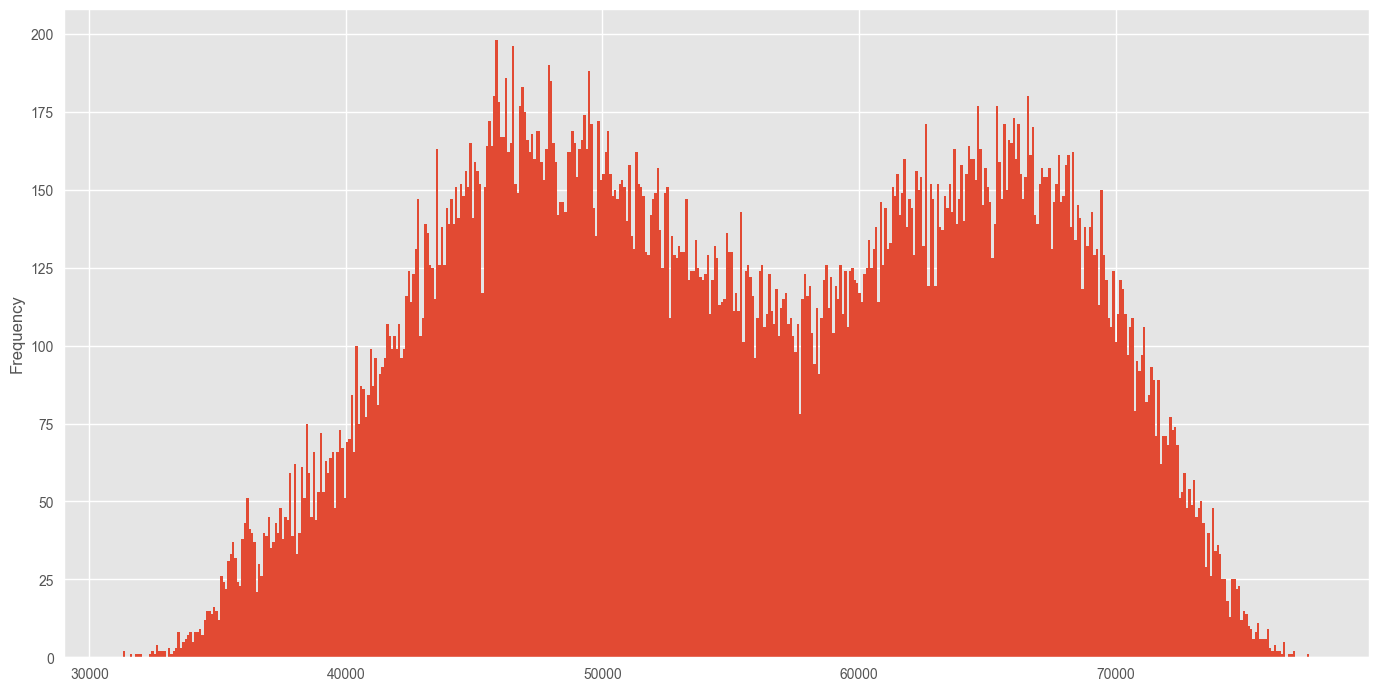

In [194]:

ts['consumption_MW'].plot(kind='hist', bins=500, figsize = (15,8))

In [195]:
#Train/Test split
train = ts.loc[ts.index <'2019-01-01']
test = ts.loc[ts.index>='2019-01-01']

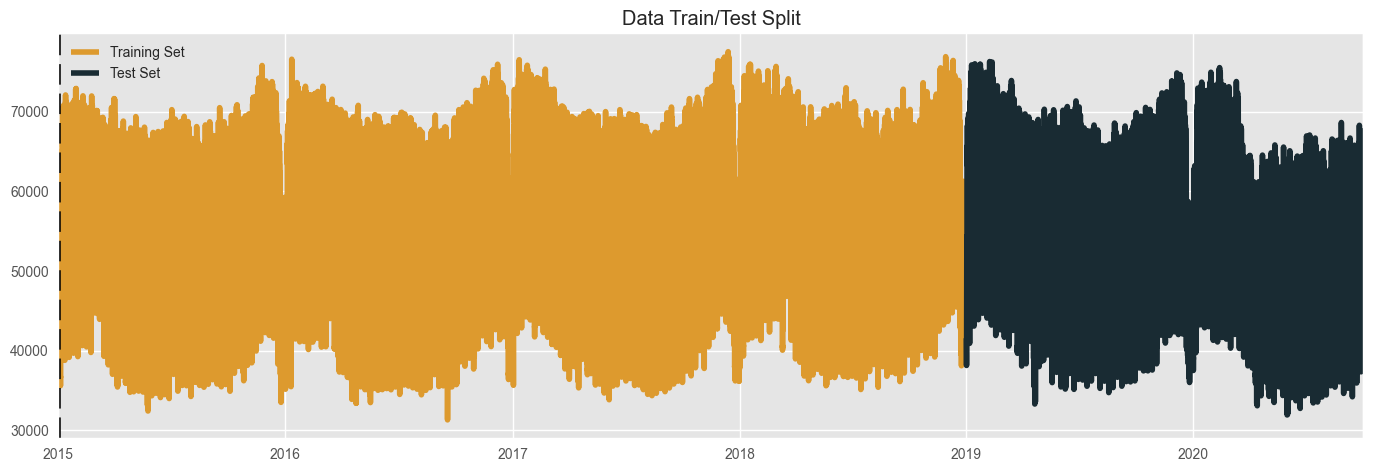

In [196]:
fig,ax = plt.subplots(figsize = (15,5))
train.plot(ax=ax, label='Training Set', title='Data Train/Test Split', color = '#dd9a2e')
test.plot(ax=ax, label='Test Set', color='#192b33')
ax.axvline('2015-01-01', color='black', ls='--')
ax.legend(['Training Set', 'Test Set'])
ax.xaxis.set_label_text('')
plt.show()


<AxesSubplot:title={'center':'Week of Data'}, xlabel='utc_timestamp'>

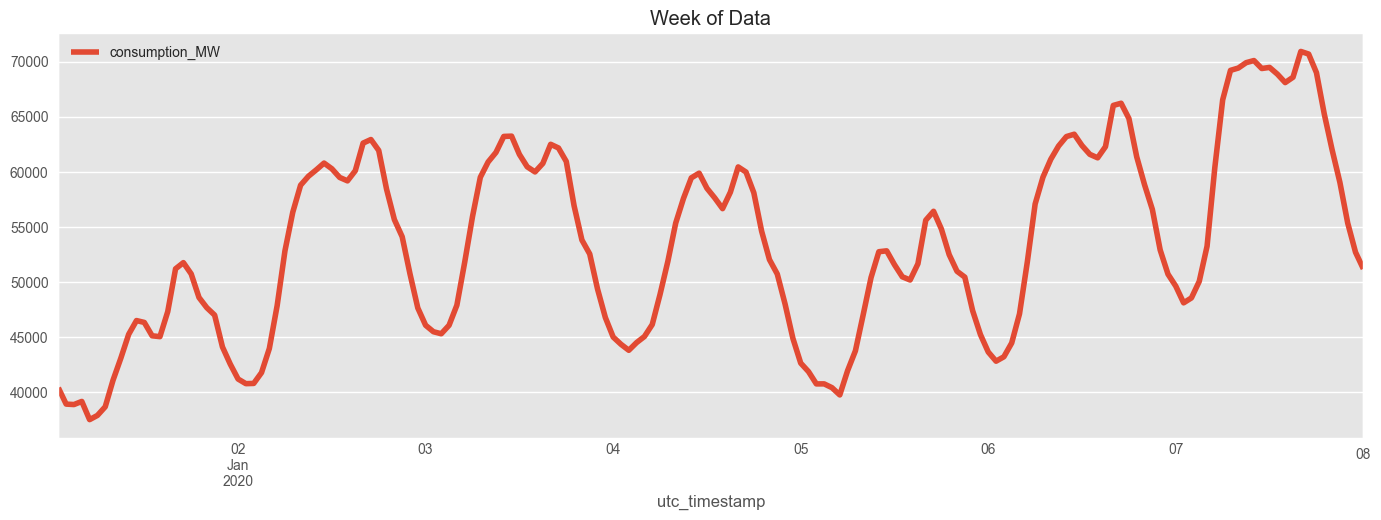

In [197]:
ts.loc[(ts.index >'2020-01-01')&(ts.index<='2020-01-08')]\
.plot(figsize = (15,5), title = 'Week of Data')


In [198]:
#Feature Creation
def create_features (df):
    """
    Create time series feature based on time series index
    """

    df['hour'] = df.index.hour
    df['dow'] = df.index.day_name()
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['doy'] = df.index.dayofyear
    df['dom'] = df.index.day
    return df


In [199]:
ts = create_features(ts)
ts.head(2)

consumption_MW  hour       dow  dayofweek  quarter  \
utc_timestamp                                                             
2015-01-01 00:00:00           41151     0  Thursday          3        1   
2015-01-01 01:00:00           40135     1  Thursday          3        1   

                     month  year  doy  dom  
utc_timestamp                               
2015-01-01 00:00:00      1  2015    1    1  
2015-01-01 01:00:00      1  2015    1    1

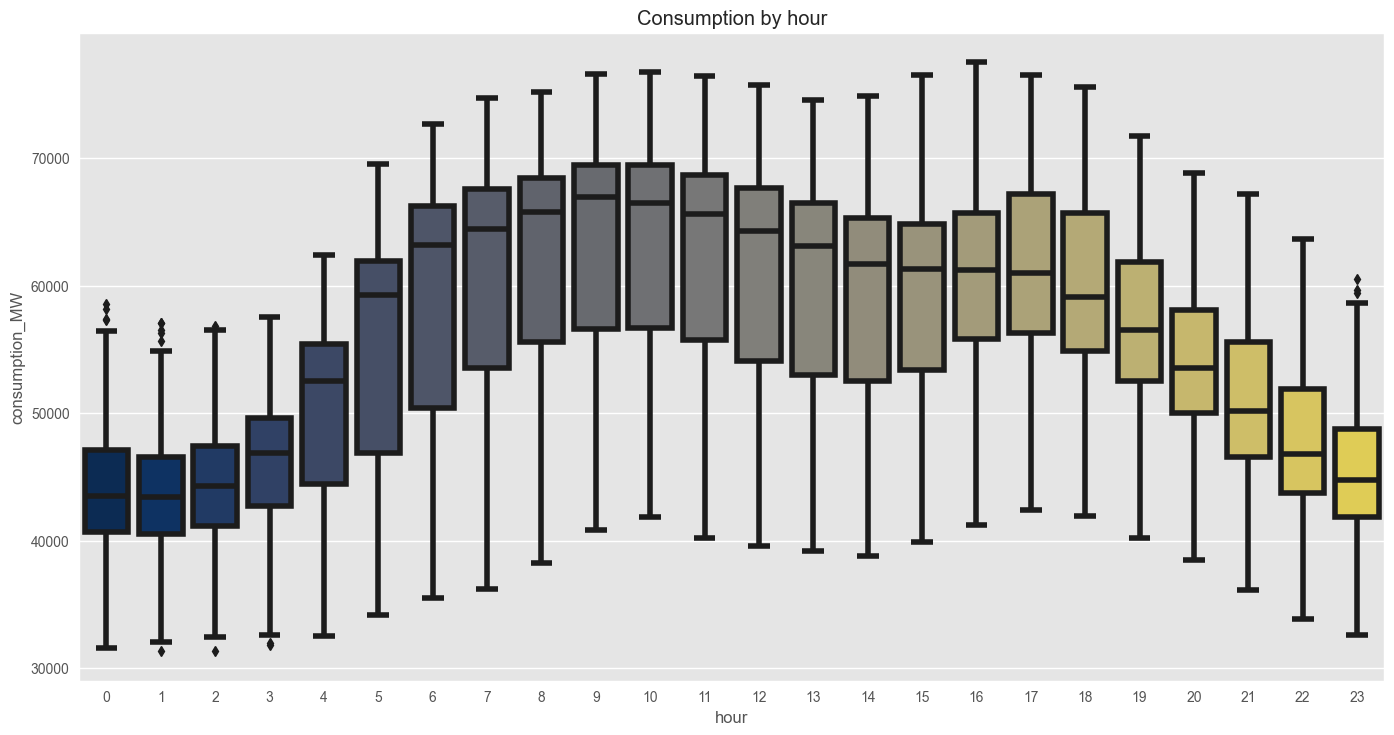

In [200]:
#Visual feature / Target relationship
fig,ax = plt.subplots(figsize=(15,8))
sns.boxplot(data=ts, x='hour',y='consumption_MW', palette = 'cividis')
ax.set_title('Consumption by hour')
fig.show()

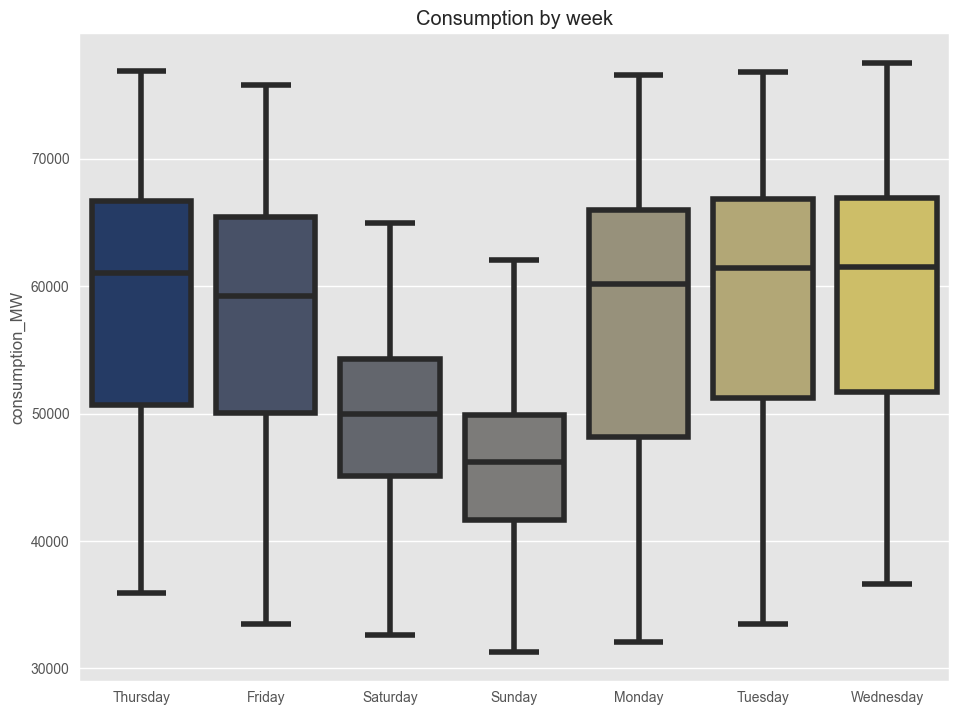

In [201]:
fig, ax = plt.subplots(figsize = (10,8))
sns.boxplot(data = ts, x = 'dow', y = 'consumption_MW', palette = 'cividis')
ax.set_title('Consumption by week')
ax.xaxis.set_label_text('')
fig.show()
           

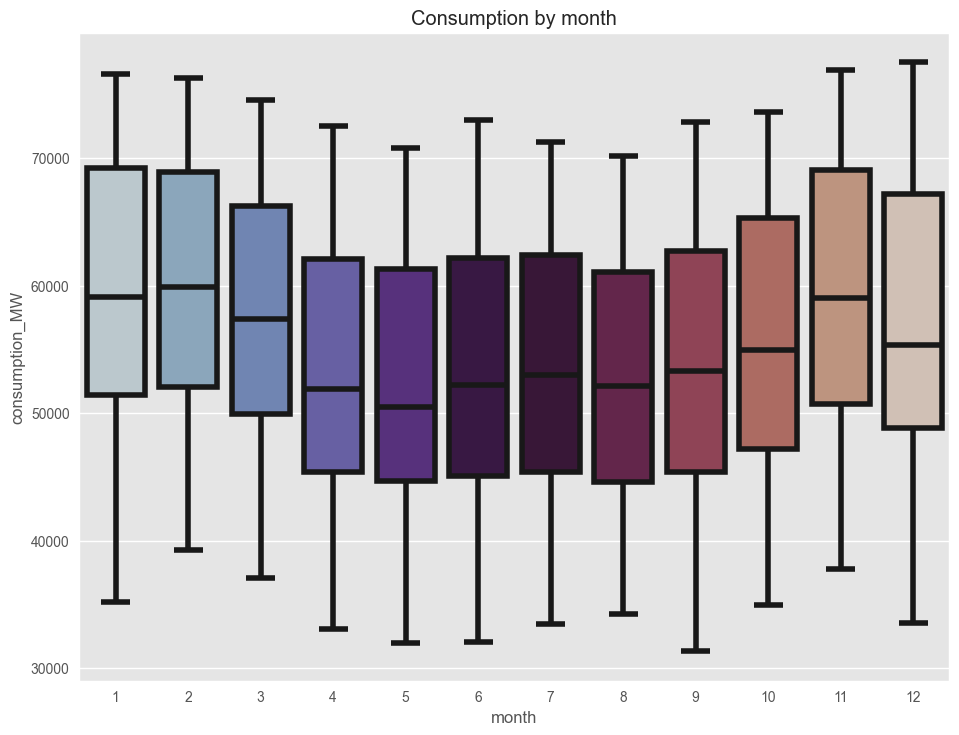

In [202]:
fig, ax = plt.subplots(figsize = (10,8))
sns.boxplot(data = ts, x = 'month', y = 'consumption_MW', palette = 'twilight')
ax.set_title('Consumption by month')
fig.show()
            

In [203]:
ts.columns

Index(['consumption_MW', 'hour', 'dow', 'dayofweek', 'quarter', 'month',
       'year', 'doy', 'dom'],
      dtype='object')

In [204]:
train

consumption_MW
utc_timestamp                      
2015-01-01 00:00:00           41151
2015-01-01 01:00:00           40135
2015-01-01 02:00:00           39106
2015-01-01 03:00:00           38765
2015-01-01 04:00:00           38941
...                             ...
2018-12-31 19:00:00           50094
2018-12-31 20:00:00           47993
2018-12-31 21:00:00           47476
2018-12-31 22:00:00           45636
2018-12-31 23:00:00           42976

[35064 rows x 1 columns]

In [205]:
#Creat the model
train = create_features(train)
test = create_features(test)


In [206]:

FEATURES = ['hour','dayofweek','quarter','month','year']
TARGET = 'consumption_MW'


In [207]:
X_train = train[FEATURES]
y_train = train[TARGET]

X_test = test[FEATURES]
y_test = test[TARGET]

In [208]:
reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',
                       n_estimators=1000,
                      early_stopping_rounds=50,
                      objective='reg:linear',
                      max_depth=3,
                      learning_rate=0.01)

In [209]:
reg.fit(X_train, y_train, 
        eval_set=[(X_train, y_train),(X_test,y_test)],
        verbose=100)

[10:43:48] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:56158.38235	validation_1-rmse:55060.25218
[100]	validation_0-rmse:21081.56862	validation_1-rmse:20071.45362
[200]	validation_0-rmse:8754.25884	validation_1-rmse:8034.80357
[300]	validation_0-rmse:4930.36817	validation_1-rmse:4664.06868
[400]	validation_0-rmse:3958.25345	validation_1-rmse:4157.17132
[463]	validation_0-rmse:3761.91261	validation_1-rmse:4180.44820


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=50, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.01, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=3, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=1000,
             n_jobs=0, num_parallel_tree=1, objective='reg:linear',
             predictor='auto', random_state=0, reg_alpha=0, ...)

In [210]:
# Feature Important
fi = pd.DataFrame(data = reg.feature_importances_,
             index = reg.feature_names_in_,
            columns = ['importance']) 
             

<AxesSubplot:title={'center':'Feature Importance'}>

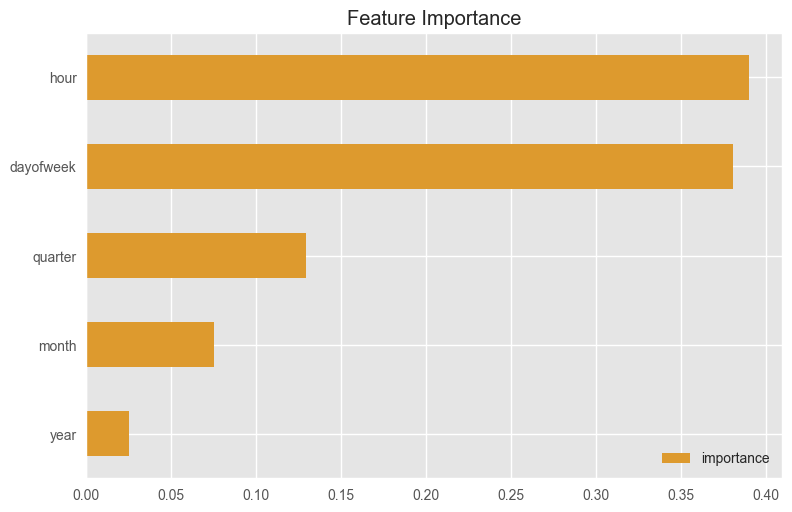

In [211]:
fi.sort_values('importance').plot(kind = 'barh', title = 'Feature Importance', color = '#dd9a2e')

In [212]:
#Forecast on Test
test['prediction'] = reg.predict(X_test)

In [213]:
ts = ts.merge(test[['prediction']], how = 'left', left_index=True, right_index=True)

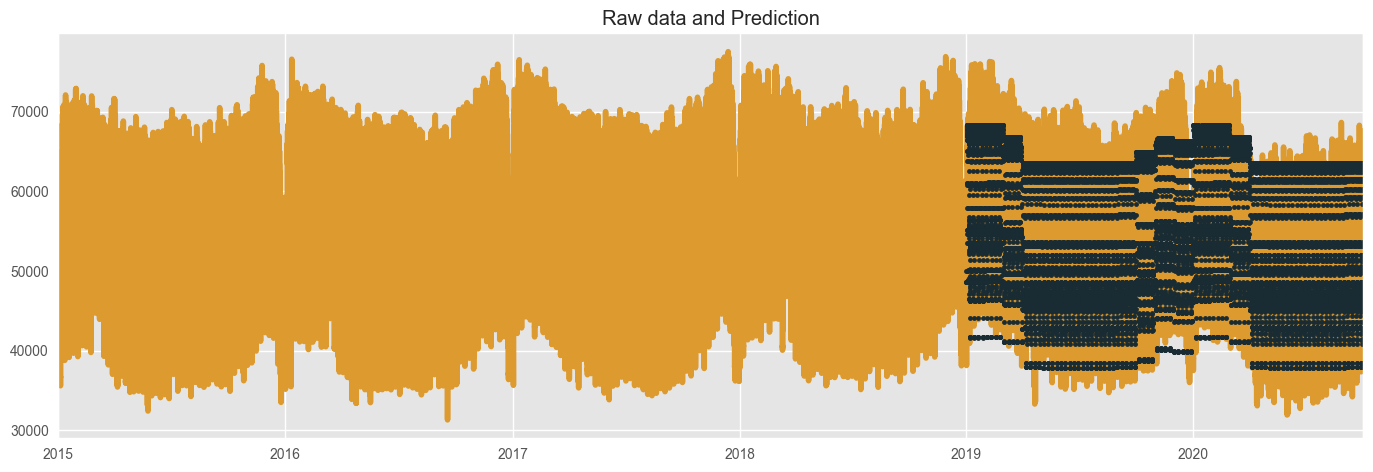

In [214]:
ax = ts[['consumption_MW']].plot(figsize = (15,5), color = ['#dd9a2e'])
ts['prediction'].plot(ax=ax, style = '.',color= '#192b33')
plt.legend('Truth Data', 'Prediction')
ax.set_title('Raw data and Prediction')
ax.xaxis.set_label_text ('')
plt.show()

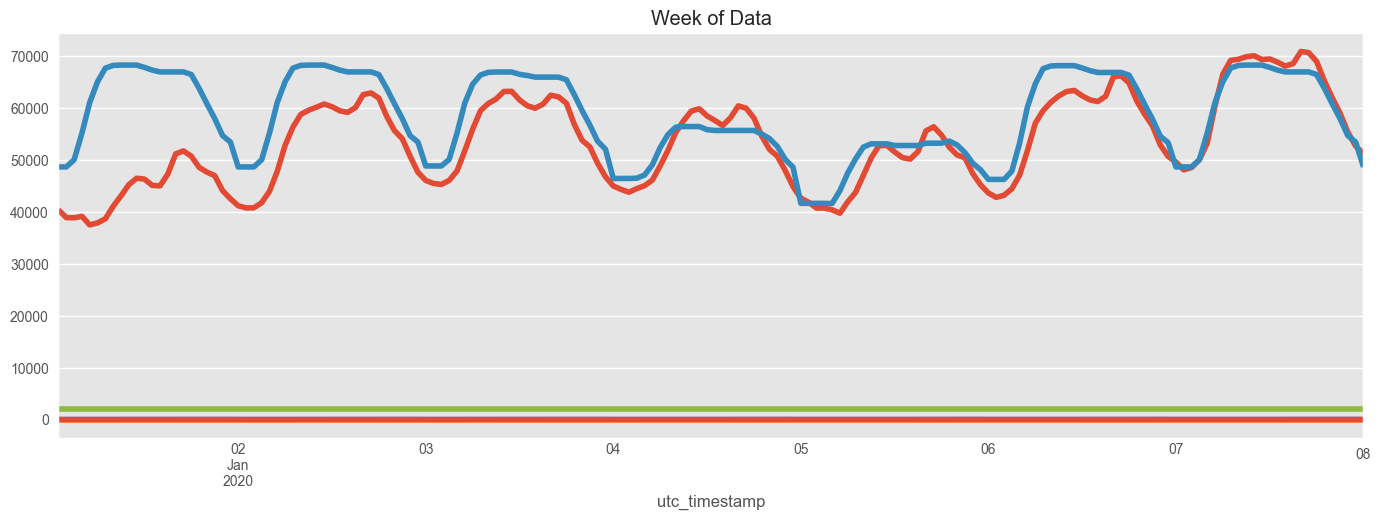

In [215]:
ts.loc[(ts.index >'2020-01-01')&(ts.index<='2020-01-08')]\
.plot(figsize = (15,5), title = 'Week of Data')
plt.legend('')
ax.xaxis.set_label_text ('')
plt.show()

The forecast is nicely followed the trend. However, the error still remains that we can do tunning. <br>
Error may be on the holiday or some special time that not followed normal trend.
Let's calculate the error and look at the worst and the best predicted date.

In [216]:
score = np.sqrt(mean_squared_error(test['consumption_MW'], test['prediction']))

In [217]:
print(f'RMSE Score on test set: {score:0.2f}')

RMSE Score on test set: 4153.70


**Calculate Error**
 - Look at the worst and best predicted date
    
    

In [218]:
test['error'] = np.abs(test['consumption_MW'] - test['prediction'])

In [219]:
test['date'] = test.index.date

In [220]:
test.groupby('date')['error'].mean().sort_values(ascending=False).head()

date
2020-01-01   17606.15
2019-12-25   16107.64
2019-12-26   16088.97
2019-01-01   15902.61
2020-06-01   15842.90
Name: error, dtype: float64

It is clearly that the worst predicted date are the holidays in Germany when consumption patterns don't follow the general trend.

In [ ]:
test.groupby('date')['error'].mean().sort_values(ascending=True).head()

# Reference
1. Priesmann, J., Nolting, L., Kockel, C. et al. Time series of useful energy consumption patterns for energy system modeling. Sci Data 8, 148 (2021). https://doi.org/10.1038/s41597-021-00907-w
2. https://www.kaggle.com/code/robikscube/time-series-forecasting-with-machine-learning-yt
3. https://medium.com/@xinyu.chen/visualizing-germany-energy-consumption-data-in-python-200e7cc3e506
4.https://towardsdatascience.com/2-efficient-ways-of-creating-fancy-pictogram-charts-in-python-8b77d361d500
5. https://www.youtube.com/watch?v=QAqi77tA_1s
6. https://learndataanalysis.org/how-to-save-matplotlib-chart-as-mp4-file/
